In [1]:
from pyEDM import *
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import rasterio
import xarray as xr
from tqdm import tqdm
import datetime
import scipy.stats
from datetime import datetime
from sklearn.metrics import r2_score

import dask.dataframe as dd
import dask
dask.config.set(scheduler='threads')

from scipy import stats
from rasterio.plot import show
import geopandas as gpd
import fiona
import rasterio.mask

In [2]:
plt.style.use('dark_background')

In [3]:
observations_tables = '/home/rgreen/tana-crunch/rgreen/crunch/DroughtEDM/Data/observations_tables/'
predictions_tables = '/home/rgreen/tana-crunch/rgreen/crunch/DroughtEDM/Data/predictions_tables/'
transposed_predictions_tables = '/home/rgreen/tana-crunch/rgreen/crunch/DroughtEDM/Data/predictions_tables/'

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
Africa_basemap = world[world['continent'] == 'Africa']
EA_countries = ['Burundi', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Rwanda', 'Sudan', 'S. Sudan', 'Somalia', 'Somaliland', 'South Sudan', 'Tanzania', 'Uganda']
EastAfrica_basemap = world[world['name'].isin(EA_countries)]
#EastAfrica_basemap.to_file(Admin_boundaries + 'EastAfrica_countries.shp')

In [5]:
ndvi_ea = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/EA/'
ea_boundary = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/AdminBoundaries/EastAfrica/EastAfrica.shp'

In [6]:
EOS_maps = '/home/rgreen/DroughtEDM/Data/EOS_maps/'

In [7]:
def generate_dekads(start, end):
    '''
    Generates list of timestamps of dekads between two dates
    
    Parameters
    ----------
    start : pd.datetime object
        Start date of list
    end : pd.datetime object
        end date of list
    '''
    
    dtrange = pd.date_range(start, end)
    days = list(range(len(dtrange))) #length of dtrange
    daysDF = pd.DataFrame({'Days': days}, index=dtrange)
    d = daysDF.index.day - np.clip((daysDF.index.day-1) // 10, 0, 2)*10 - 1 
    dekaddates = daysDF.index.values - np.array(d, dtype="timedelta64[D]")
    dekads = daysDF.groupby(dekaddates).mean()
    dekads = dekads.index
    
    return dekads

In [8]:
start = pd.datetime(2002,7,1)
end = pd.datetime(2019,4,30)

dekads = generate_dekads(start, end)

In [9]:
dekads_pi1 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,5,1))
dekads_pi2 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,5,11))
dekads_pi3 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,5,21))
dekads_pi4 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,6,1))
dekads_pi5 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,6,11))
dekads_pi6 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,6,21))
dekads_pi7 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,7,1))
dekads_pi8 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,7,11))
dekads_pi9 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,7,21))
dekads_pi10 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,8,1))
dekads_pi11 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,8,11))
dekads_pi12 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,8,21))

In [10]:
ndvi_table = pd.read_csv(observations_tables+'ndvi_table_anomT.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])

In [11]:
lc_pixels_skill = pd.read_csv('/home/rgreen/DroughtEDM/Data/LCs_pixels/lc_pixels_skill.csv',index_col=[0])

In [12]:
lc_pixels_skill

,pixel_id,LC,skill
0,863,shrubland,0.660811
1,2046,grassland,0.366358
2,2518,cropland_irrigated,0.495580
3,2629,grassland,0.335566
4,3098,cropland_irrigated,0.407682
...,...,...,...
113170,392068,woodland,0.956308
113171,392069,woodland,0.961195
113172,392646,woodland,0.953059
113173,392648,woodland,0.949436


In [13]:
ndvi_table.columns = dekads.strftime("%Y-%m-%d").tolist()

In [14]:
lc_pixel_ids = lc_pixels_skill.pixel_id.tolist()

In [15]:
ndvi_table_lct = ndvi_table.loc[lc_pixel_ids]


In [16]:
ndvi_table_lct.insert(0, 'lc', list(lc_pixels_skill.LC))

In [17]:
ndvi_table_lct

,lc,2002-07-01,2002-07-11,2002-07-21,2002-08-01,2002-08-11,2002-08-21,2002-09-01,2002-09-11,2002-09-21,...,2019-01-21,2019-02-01,2019-02-11,2019-02-21,2019-03-01,2019-03-11,2019-03-21,2019-04-01,2019-04-11,2019-04-21
863,shrubland,-1.475433,-1.518405,-1.282363,-1.037406,-0.748854,-0.677849,-0.508037,-0.687356,-0.834098,...,1.412241,1.181153,1.161822,1.091886,1.341829,0.930353,0.687070,0.200312,-0.143186,-0.416006
2046,grassland,0.240269,-0.040980,-0.322507,-0.377474,-0.753954,-0.591410,-0.412689,-0.203892,-0.267931,...,1.375149,1.156387,1.045291,0.708260,0.148880,-0.277729,-0.490101,-0.563189,-0.730995,-0.938608
2518,cropland_irrigated,-0.526155,-0.467407,-0.558128,-0.576396,-0.711478,-0.860418,-1.076931,-1.212559,-1.317824,...,-1.457113,-1.350243,-1.370575,-1.449260,-1.440804,-1.500194,-1.572480,-1.673113,-1.685067,-1.699210
2629,grassland,-0.177351,-0.444964,-0.485958,-0.531228,-0.941552,-0.892083,-0.722203,-0.469486,-0.496443,...,2.605408,2.261347,1.933121,1.327076,0.569753,0.154415,0.023260,-0.184576,-0.362062,-0.545488
3098,cropland_irrigated,-0.325597,-0.601886,-0.464239,-0.258413,-0.157339,-0.176319,-0.415176,-0.596674,-0.711229,...,-1.248104,-1.203020,-1.197067,-1.239635,-1.260338,-1.337919,-1.379773,-1.338771,-1.335912,-1.339261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392068,woodland,-0.025340,0.016160,-0.049351,-0.068330,-0.203531,-0.366857,-0.615098,-0.850613,-1.088054,...,0.360896,0.540712,0.835455,1.089923,1.112593,1.178492,1.238674,1.272190,1.227286,1.238984
392069,woodland,0.109000,0.108357,-0.033553,-0.121138,-0.330355,-0.561626,-0.809041,-1.001596,-1.150593,...,0.926585,1.212811,1.253882,1.143525,0.958708,1.040234,1.195903,1.300901,1.312978,1.270954
392646,woodland,-0.085271,-0.064275,-0.169206,-0.259496,-0.555283,-0.885655,-1.176302,-1.325936,-1.348795,...,1.028716,1.070543,1.136970,1.253189,1.317058,1.278181,1.201858,1.146975,1.159195,1.187477
392648,woodland,-0.143125,-0.129708,-0.197331,-0.241803,-0.450817,-0.684081,-0.958579,-1.160011,-1.295572,...,0.911191,0.764701,0.771033,0.954767,1.203470,1.279771,1.258993,1.231620,1.197543,1.174859


In [18]:
#precip_table = pd.read_csv(observations_tables+'precip_table_anomT.csv',delimiter=',', engine='c', low_memory=False, index_col=[0])

In [7]:
#temp_table = pd.read_csv(observations_tables+'temp_table_anomT.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])

Load Observation Tables transposed with land cover column

In [12]:
#ndvi_table_lct = pd.read_csv(observations_tables+'ndvi_table_anom_lct.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])

In [198]:
#precip_table_lct = pd.read_csv(observations_tables+'precip_table_anom_lct.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])

In [10]:
#temp_table_lct = pd.read_csv(observations_tables+'temp_table_anom_lct.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])

In [19]:
first_cols= ['2002-07-01', '2002-07-11', '2002-07-21', '2002-08-01', '2002-08-11']

In [20]:
ndvi_table_lct.drop(first_cols,axis=1)

,lc,2002-08-21,2002-09-01,2002-09-11,2002-09-21,2002-10-01,2002-10-11,2002-10-21,2002-11-01,2002-11-11,...,2019-01-21,2019-02-01,2019-02-11,2019-02-21,2019-03-01,2019-03-11,2019-03-21,2019-04-01,2019-04-11,2019-04-21
863,shrubland,-0.677849,-0.508037,-0.687356,-0.834098,-1.018043,-0.819319,-0.359399,0.164762,0.717623,...,1.412241,1.181153,1.161822,1.091886,1.341829,0.930353,0.687070,0.200312,-0.143186,-0.416006
2046,grassland,-0.591410,-0.412689,-0.203892,-0.267931,-0.199502,-0.076608,0.168946,0.380871,0.403617,...,1.375149,1.156387,1.045291,0.708260,0.148880,-0.277729,-0.490101,-0.563189,-0.730995,-0.938608
2518,cropland_irrigated,-0.860418,-1.076931,-1.212559,-1.317824,-1.377653,-1.301925,-1.319315,-1.190101,-1.041641,...,-1.457113,-1.350243,-1.370575,-1.449260,-1.440804,-1.500194,-1.572480,-1.673113,-1.685067,-1.699210
2629,grassland,-0.892083,-0.722203,-0.469486,-0.496443,-0.376322,-0.241315,-0.081462,0.035120,0.041507,...,2.605408,2.261347,1.933121,1.327076,0.569753,0.154415,0.023260,-0.184576,-0.362062,-0.545488
3098,cropland_irrigated,-0.176319,-0.415176,-0.596674,-0.711229,-0.849393,-0.995835,-1.088345,-1.081939,-1.058045,...,-1.248104,-1.203020,-1.197067,-1.239635,-1.260338,-1.337919,-1.379773,-1.338771,-1.335912,-1.339261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392068,woodland,-0.366857,-0.615098,-0.850613,-1.088054,-1.272568,-1.412282,-1.420599,-1.287024,-1.001712,...,0.360896,0.540712,0.835455,1.089923,1.112593,1.178492,1.238674,1.272190,1.227286,1.238984
392069,woodland,-0.561626,-0.809041,-1.001596,-1.150593,-1.228858,-1.257589,-1.186864,-1.006688,-0.742660,...,0.926585,1.212811,1.253882,1.143525,0.958708,1.040234,1.195903,1.300901,1.312978,1.270954
392646,woodland,-0.885655,-1.176302,-1.325936,-1.348795,-1.334347,-1.314530,-1.245479,-1.043998,-0.744776,...,1.028716,1.070543,1.136970,1.253189,1.317058,1.278181,1.201858,1.146975,1.159195,1.187477
392648,woodland,-0.684081,-0.958579,-1.160011,-1.295572,-1.356797,-1.375180,-1.317771,-1.174778,-0.917691,...,0.911191,0.764701,0.771033,0.954767,1.203470,1.279771,1.258993,1.231620,1.197543,1.174859


In [21]:
ndvi_table_lct_crop_rain = ndvi_table_lct.loc[ndvi_table_lct['lc'] == 'cropland_rainfed'].drop(first_cols,axis=1).iloc[:, 1:]
ndvi_table_lct_crop_irr = ndvi_table_lct.loc[ndvi_table_lct['lc'] == 'cropland_irrigated'].drop(first_cols,axis=1).iloc[:, 1:]

In [22]:
ndvi_table_lct_crop_rain

,2002-08-21,2002-09-01,2002-09-11,2002-09-21,2002-10-01,2002-10-11,2002-10-21,2002-11-01,2002-11-11,2002-11-21,...,2019-01-21,2019-02-01,2019-02-11,2019-02-21,2019-03-01,2019-03-11,2019-03-21,2019-04-01,2019-04-11,2019-04-21
3681,-0.270593,-0.478537,-0.660685,-0.868090,-1.098393,-1.290870,-1.435266,-1.469472,-1.403043,-1.349501,...,-1.208258,-1.181177,-1.204368,-1.261320,-1.307901,-1.344215,-1.385337,-1.352298,-1.332319,-1.301558
41006,-1.512279,-1.664075,-1.724623,-1.723886,-1.595127,-1.377226,-1.225280,-0.979884,-0.664232,-0.392790,...,2.235425,2.216528,2.126565,1.967632,1.856236,1.818682,1.816057,1.742356,1.630767,1.540587
51543,-1.784805,-1.701006,-1.595591,-1.407119,-1.174840,-0.965093,-0.881531,-0.793768,-0.680452,-0.585520,...,2.275173,2.079064,1.842205,1.564016,1.315884,1.204292,1.131393,1.088767,1.131291,1.190842
52208,-0.016895,0.240334,0.229659,0.096335,-0.097060,-0.167231,-0.151784,-0.066912,-0.038218,-0.085456,...,0.353230,0.182501,-0.004501,-0.241436,-0.422995,-0.557729,-0.656272,-0.700434,-0.759270,-0.824410
53372,-0.549178,-0.288056,-0.175415,-0.153467,-0.157759,-0.179820,-0.198784,-0.194044,-0.200650,-0.261573,...,0.119382,-0.001034,-0.067838,-0.164091,-0.287094,-0.378470,-0.468722,-0.590634,-0.650204,-0.697443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382709,-0.706454,-0.913128,-1.053881,-1.136760,-1.161517,-1.215711,-1.290766,-1.260528,-0.999856,-0.445269,...,0.183703,0.723782,1.444733,1.690083,1.657176,1.519990,1.347329,1.205476,1.233788,1.193838
383868,-0.446955,-0.710923,-0.890344,-0.994962,-1.105833,-1.214002,-1.255073,-1.077911,-0.670502,-0.114927,...,1.630136,1.636632,1.582478,1.399251,1.165942,1.049660,0.824272,0.435113,1.024952,0.598294
383942,-0.458944,-0.543131,-0.601427,-0.692242,-0.816226,-0.924419,-1.003202,-1.032406,-0.985315,-0.909013,...,0.021017,-0.286828,-0.099834,0.524881,1.135544,1.410446,1.531154,1.548511,1.509661,1.425078
385086,-1.039475,-1.313737,-1.337247,-1.240819,-1.075340,-1.025469,-0.952001,-0.782969,-0.452268,-0.092699,...,-0.561577,-0.727608,-0.173896,0.516886,1.062741,1.428352,1.547069,1.606028,1.713779,1.492180


In [23]:
lc_pixels = ndvi_table_lct.index.tolist()

In [24]:
lc_col = ndvi_table_lct.lc

In [60]:
#lc_col = lc_col.to_frame()

In [61]:
#lc_col.to_csv('/home/rgreen/DroughtEDM/Data/LCs_pixels/lc_pixels.csv')

Load Prediction Tables transposed

In [18]:
# ndvi_ea_simplex_ed6_pi1 = pd.read_csv(predictions_tables+ 'ndvi_ea_simplex_ed6_pi1.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
# ndvi_ea_simplex_ed6_pi2 = pd.read_csv(predictions_tables+ 'ndvi_ea_simplex_ed6_pi2.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
# ndvi_ea_simplex_ed6_pi3 = pd.read_csv(predictions_tables+ 'ndvi_ea_simplex_ed6_pi3.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
# ndvi_ea_simplex_ed6_pi4 = pd.read_csv(predictions_tables+ 'ndvi_ea_simplex_ed6_pi4.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
# ndvi_ea_simplex_ed6_pi5 = pd.read_csv(predictions_tables+ 'ndvi_ea_simplex_ed6_pi5.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
# ndvi_ea_simplex_ed6_pi6 = pd.read_csv(predictions_tables+ 'ndvi_ea_simplex_ed6_pi6.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
# ndvi_ea_simplex_ed6_pi7 = pd.read_csv(predictions_tables+ 'ndvi_ea_simplex_ed6_pi7.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
# ndvi_ea_simplex_ed6_pi8 = pd.read_csv(predictions_tables+ 'ndvi_ea_simplex_ed6_pi8.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
# ndvi_ea_simplex_ed6_pi9 = pd.read_csv(predictions_tables+ 'ndvi_ea_simplex_ed6_pi9.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
# ndvi_ea_simplex_ed6_pi10 = pd.read_csv(predictions_tables+ 'ndvi_ea_simplex_ed6_pi10.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
# ndvi_ea_simplex_ed6_pi11 = pd.read_csv(predictions_tables+ 'ndvi_ea_simplex_ed6_pi11.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
# ndvi_ea_simplex_ed6_pi12 = pd.read_csv(predictions_tables+ 'ndvi_ea_simplex_ed6_pi12.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])

In [21]:
# ndvi_ea_simplex_ed6_pi1T = ndvi_ea_simplex_ed6_pi1.T.reset_index(drop=True)
# ndvi_ea_simplex_ed6_pi2T = ndvi_ea_simplex_ed6_pi2.T.reset_index(drop=True)
# ndvi_ea_simplex_ed6_pi3T = ndvi_ea_simplex_ed6_pi3.T.reset_index(drop=True)
# ndvi_ea_simplex_ed6_pi4T = ndvi_ea_simplex_ed6_pi4.T.reset_index(drop=True)
# ndvi_ea_simplex_ed6_pi5T = ndvi_ea_simplex_ed6_pi5.T.reset_index(drop=True)
# ndvi_ea_simplex_ed6_pi6T = ndvi_ea_simplex_ed6_pi6.T.reset_index(drop=True)
# ndvi_ea_simplex_ed6_pi7T = ndvi_ea_simplex_ed6_pi7.T.reset_index(drop=True)
# ndvi_ea_simplex_ed6_pi8T = ndvi_ea_simplex_ed6_pi8.T.reset_index(drop=True)
# ndvi_ea_simplex_ed6_pi9T = ndvi_ea_simplex_ed6_pi9.T.reset_index(drop=True)
# ndvi_ea_simplex_ed6_pi10T = ndvi_ea_simplex_ed6_pi10.T.reset_index(drop=True)
# ndvi_ea_simplex_ed6_pi11T = ndvi_ea_simplex_ed6_pi11.T.reset_index(drop=True)
# ndvi_ea_simplex_ed6_pi12T = ndvi_ea_simplex_ed6_pi12.T.reset_index(drop=True)

In [197]:
# ndvi_ea_simplex_ed6_pi1T.to_csv(transformed_predictions_tables + 'ndvi_ea_simplex_ed6_pi1T.csv')
# ndvi_ea_simplex_ed6_pi2T.to_csv(transformed_predictions_tables + 'ndvi_ea_simplex_ed6_pi2T.csv')
# ndvi_ea_simplex_ed6_pi3T.to_csv(transformed_predictions_tables + 'ndvi_ea_simplex_ed6_pi3T.csv')
# ndvi_ea_simplex_ed6_pi4T.to_csv(transformed_predictions_tables + 'ndvi_ea_simplex_ed6_pi4T.csv')
# ndvi_ea_simplex_ed6_pi5T.to_csv(transformed_predictions_tables + 'ndvi_ea_simplex_ed6_pi5T.csv')
# ndvi_ea_simplex_ed6_pi6T.to_csv(transformed_predictions_tables + 'ndvi_ea_simplex_ed6_pi6T.csv')
# ndvi_ea_simplex_ed6_pi7T.to_csv(transformed_predictions_tables + 'ndvi_ea_simplex_ed6_pi7T.csv')
# ndvi_ea_simplex_ed6_pi8T.to_csv(transformed_predictions_tables + 'ndvi_ea_simplex_ed6_pi8T.csv')
# ndvi_ea_simplex_ed6_pi9T.to_csv(transformed_predictions_tables + 'ndvi_ea_simplex_ed6_pi9T.csv')
# ndvi_ea_simplex_ed6_pi10T.to_csv(transformed_predictions_tables + 'ndvi_ea_simplex_ed6_pi10T.csv')
# ndvi_ea_simplex_ed6_pi11T.to_csv(transformed_predictions_tables + 'ndvi_ea_simplex_ed6_pi11T.csv')
# ndvi_ea_simplex_ed6_pi12T.to_csv(transformed_predictions_tables + 'ndvi_ea_simplex_ed6_pi12T.csv')

In [25]:
ndvi_ea_simplex_ed6_pi1T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi1T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi2T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi2T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi3T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi3T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi4T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi4T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi5T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi5T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi6T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi6T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi7T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi7T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi8T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi8T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi9T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi9T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi10T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi10T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi11T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi11T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi12T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi12T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])

In [26]:
ndvi_ea_simplex_ed6_pi1T.columns = dekads_pi1.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi2T.columns = dekads_pi2.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi3T.columns = dekads_pi3.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi4T.columns = dekads_pi4.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi5T.columns = dekads_pi5.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi6T.columns = dekads_pi6.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi7T.columns = dekads_pi7.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi8T.columns = dekads_pi8.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi9T.columns = dekads_pi9.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi10T.columns = dekads_pi10.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi11T.columns = dekads_pi11.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi12T.columns = dekads_pi12.strftime("%Y-%m-%d").tolist()

In [27]:
ndvi_ea_simplex_ed6_pi12T

,2002-08-21,2002-09-01,2002-09-11,2002-09-21,2002-10-01,2002-10-11,2002-10-21,2002-11-01,2002-11-11,2002-11-21,...,2019-05-21,2019-06-01,2019-06-11,2019-06-21,2019-07-01,2019-07-11,2019-07-21,2019-08-01,2019-08-11,2019-08-21
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.298416,0.178059,0.244730,0.373254,0.303175,0.271796,0.382673,0.486490,0.482106,1.071114
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.415464,0.066738,0.257801,0.456940,0.802241,1.138978,0.867417,0.581346,0.474430,0.735709
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.527398,0.362171,0.581762,0.609131,0.797350,1.006382,1.002250,0.792629,0.619123,0.470386
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.056555,0.227386,0.673208,0.744636,0.582376,0.821647,0.611962,0.428411,-0.019953,0.565635
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.116354,0.299946,0.665202,0.336636,0.408385,1.001959,0.861142,0.542073,0.702467,0.987653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
392938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
392939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
392940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
ndvi_ea_simplex_ed6_pi1T_lcp = ndvi_ea_simplex_ed6_pi1T.loc[lc_pixels]
ndvi_ea_simplex_ed6_pi2T_lcp = ndvi_ea_simplex_ed6_pi2T.loc[lc_pixels]
ndvi_ea_simplex_ed6_pi3T_lcp = ndvi_ea_simplex_ed6_pi3T.loc[lc_pixels]
ndvi_ea_simplex_ed6_pi4T_lcp = ndvi_ea_simplex_ed6_pi4T.loc[lc_pixels]
ndvi_ea_simplex_ed6_pi5T_lcp = ndvi_ea_simplex_ed6_pi5T.loc[lc_pixels]
ndvi_ea_simplex_ed6_pi6T_lcp = ndvi_ea_simplex_ed6_pi6T.loc[lc_pixels]
ndvi_ea_simplex_ed6_pi7T_lcp = ndvi_ea_simplex_ed6_pi7T.loc[lc_pixels]
ndvi_ea_simplex_ed6_pi8T_lcp = ndvi_ea_simplex_ed6_pi8T.loc[lc_pixels]
ndvi_ea_simplex_ed6_pi9T_lcp = ndvi_ea_simplex_ed6_pi9T.loc[lc_pixels]
ndvi_ea_simplex_ed6_pi10T_lcp = ndvi_ea_simplex_ed6_pi10T.loc[lc_pixels]
ndvi_ea_simplex_ed6_pi11T_lcp = ndvi_ea_simplex_ed6_pi11T.loc[lc_pixels]
ndvi_ea_simplex_ed6_pi12T_lcp = ndvi_ea_simplex_ed6_pi12T.loc[lc_pixels]

In [29]:
ndvi_ea_simplex_ed6_pi1T_lcp

,2002-08-21,2002-09-01,2002-09-11,2002-09-21,2002-10-01,2002-10-11,2002-10-21,2002-11-01,2002-11-11,2002-11-21,...,2019-02-01,2019-02-11,2019-02-21,2019-03-01,2019-03-11,2019-03-21,2019-04-01,2019-04-11,2019-04-21,2019-05-01
863,NaN,-0.770993,-0.648885,-0.813492,-0.605606,-0.346719,-0.392662,0.019755,0.562829,0.823850,...,1.298471,1.063467,0.852006,0.684266,0.587565,0.400777,0.228304,-0.187587,-0.268673,-0.472115
2046,NaN,-0.185840,-0.251012,-0.225010,-0.164242,-0.076374,-0.084134,0.213500,0.362469,0.175578,...,0.549426,0.442381,0.456868,0.540912,-0.023050,-0.386095,-0.772342,-0.749933,-0.888049,-1.132594
2518,NaN,-0.767347,-0.806239,-0.965469,-1.080046,-1.258050,-1.306939,-1.295580,-1.201068,-1.105075,...,-1.384299,-1.542258,-1.573674,-1.633397,-1.575971,-1.584115,-1.705123,-1.620171,-1.594636,-1.550482
2629,NaN,-0.367675,-0.501203,-0.333956,-0.497981,-0.461173,-0.308106,0.037759,0.276980,0.486357,...,1.908828,1.739188,1.675292,0.975675,0.508741,0.223878,0.023357,-0.280234,-0.317618,-0.543488
3098,NaN,-0.253387,-0.224746,-0.413457,-0.700721,-0.891673,-1.072256,-1.102277,-1.084720,-1.094504,...,-1.271371,-1.255931,-1.228155,-1.278834,-1.215278,-1.117331,-1.186130,-1.245164,-1.231197,-1.218637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392068,NaN,-0.799928,-0.897618,-1.089980,-1.264658,-1.420367,-1.503452,-1.532226,-1.436805,-0.990679,...,0.643944,0.659757,0.911132,0.960020,1.008385,1.082826,1.146845,1.124811,1.222826,1.241574
392069,NaN,-0.807304,-0.951976,-1.123454,-1.260746,-1.352309,-1.374516,-1.331688,-1.271668,-0.838624,...,0.741382,0.899454,1.121419,1.149758,0.968369,1.135001,1.120808,1.172277,1.273479,1.300302
392646,NaN,-1.068299,-1.224483,-1.346092,-1.395162,-1.399347,-1.341097,-1.266955,-1.157880,-0.450172,...,0.964833,0.971722,1.110771,1.091706,1.056206,1.083412,1.143901,1.186352,1.269913,1.221547
392648,NaN,-1.045960,-1.115342,-1.163423,-1.316330,-1.383292,-1.397405,-1.351013,-1.200787,-0.650075,...,0.845492,0.855423,0.998174,1.013315,1.022848,1.263987,1.130887,1.164612,1.271657,1.219467


In [30]:
ndvi_ea_simplex_ed6_pi1T_lcp.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi2T_lcp.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi3T_lcp.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi4T_lcp.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi5T_lcp.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi6T_lcp.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi7T_lcp.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi8T_lcp.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi9T_lcp.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi10T_lcp.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi11T_lcp.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi12T_lcp.index.name='pixel_id'

In [31]:
ndvi_ea_simplex_ed6_pi1T_lcp.insert(0, 'lc', lc_col)
ndvi_ea_simplex_ed6_pi2T_lcp.insert(0, 'lc', lc_col)
ndvi_ea_simplex_ed6_pi3T_lcp.insert(0, 'lc', lc_col)
ndvi_ea_simplex_ed6_pi4T_lcp.insert(0, 'lc', lc_col)
ndvi_ea_simplex_ed6_pi5T_lcp.insert(0, 'lc', lc_col)
ndvi_ea_simplex_ed6_pi6T_lcp.insert(0, 'lc', lc_col)
ndvi_ea_simplex_ed6_pi7T_lcp.insert(0, 'lc', lc_col)
ndvi_ea_simplex_ed6_pi8T_lcp.insert(0, 'lc', lc_col)
ndvi_ea_simplex_ed6_pi9T_lcp.insert(0, 'lc', lc_col)
ndvi_ea_simplex_ed6_pi10T_lcp.insert(0, 'lc', lc_col)
ndvi_ea_simplex_ed6_pi11T_lcp.insert(0, 'lc', lc_col)
ndvi_ea_simplex_ed6_pi12T_lcp.insert(0, 'lc', lc_col)

In [32]:
ndvi_simplex_pi1T_crop_rain = ndvi_ea_simplex_ed6_pi1T_lcp.loc[ndvi_ea_simplex_ed6_pi1T_lcp['lc'] =='cropland_rainfed'].iloc[:, 1:-1]
ndvi_simplex_pi2T_crop_rain = ndvi_ea_simplex_ed6_pi2T_lcp.loc[ndvi_ea_simplex_ed6_pi2T_lcp['lc'] =='cropland_rainfed'].iloc[:, 1:-1]
ndvi_simplex_pi3T_crop_rain = ndvi_ea_simplex_ed6_pi3T_lcp.loc[ndvi_ea_simplex_ed6_pi3T_lcp['lc'] =='cropland_rainfed'].iloc[:, 1:-1]
ndvi_simplex_pi4T_crop_rain = ndvi_ea_simplex_ed6_pi4T_lcp.loc[ndvi_ea_simplex_ed6_pi4T_lcp['lc'] =='cropland_rainfed'].iloc[:, 1:-1]
ndvi_simplex_pi5T_crop_rain = ndvi_ea_simplex_ed6_pi5T_lcp.loc[ndvi_ea_simplex_ed6_pi5T_lcp['lc'] =='cropland_rainfed'].iloc[:, 1:-1]
ndvi_simplex_pi6T_crop_rain = ndvi_ea_simplex_ed6_pi6T_lcp.loc[ndvi_ea_simplex_ed6_pi6T_lcp['lc'] =='cropland_rainfed'].iloc[:, 1:-1]
ndvi_simplex_pi7T_crop_rain = ndvi_ea_simplex_ed6_pi7T_lcp.loc[ndvi_ea_simplex_ed6_pi7T_lcp['lc'] =='cropland_rainfed'].iloc[:, 1:-1]
ndvi_simplex_pi8T_crop_rain = ndvi_ea_simplex_ed6_pi8T_lcp.loc[ndvi_ea_simplex_ed6_pi8T_lcp['lc'] =='cropland_rainfed'].iloc[:, 1:-1]
ndvi_simplex_pi9T_crop_rain = ndvi_ea_simplex_ed6_pi9T_lcp.loc[ndvi_ea_simplex_ed6_pi9T_lcp['lc'] =='cropland_rainfed'].iloc[:, 1:-1]
ndvi_simplex_pi10T_crop_rain = ndvi_ea_simplex_ed6_pi10T_lcp.loc[ndvi_ea_simplex_ed6_pi10T_lcp['lc'] =='cropland_rainfed'].iloc[:, 1:-1]
ndvi_simplex_pi11T_crop_rain = ndvi_ea_simplex_ed6_pi11T_lcp.loc[ndvi_ea_simplex_ed6_pi11T_lcp['lc'] =='cropland_rainfed'].iloc[:, 1:-1]
ndvi_simplex_pi12T_crop_rain = ndvi_ea_simplex_ed6_pi12T_lcp.loc[ndvi_ea_simplex_ed6_pi12T_lcp['lc'] =='cropland_rainfed'].iloc[:, 1:-1]


In [33]:
ndvi_pred_tables_crop_rain = [ndvi_simplex_pi1T_crop_rain, ndvi_simplex_pi2T_crop_rain, ndvi_simplex_pi3T_crop_rain, ndvi_simplex_pi4T_crop_rain, ndvi_simplex_pi5T_crop_rain, ndvi_simplex_pi6T_crop_rain, ndvi_simplex_pi7T_crop_rain, ndvi_simplex_pi8T_crop_rain, ndvi_simplex_pi9T_crop_rain, ndvi_simplex_pi10T_crop_rain, ndvi_simplex_pi11T_crop_rain, ndvi_simplex_pi12T_crop_rain]



In [34]:
ndvi_simplex_pi1T_crop_irr = ndvi_ea_simplex_ed6_pi1T_lcp.loc[ndvi_ea_simplex_ed6_pi1T_lcp['lc'] =='cropland_irrigated'].iloc[:, 1:-1]
ndvi_simplex_pi2T_crop_irr = ndvi_ea_simplex_ed6_pi2T_lcp.loc[ndvi_ea_simplex_ed6_pi2T_lcp['lc'] =='cropland_irrigated'].iloc[:, 1:-1]
ndvi_simplex_pi3T_crop_irr = ndvi_ea_simplex_ed6_pi3T_lcp.loc[ndvi_ea_simplex_ed6_pi3T_lcp['lc'] =='cropland_irrigated'].iloc[:, 1:-1]
ndvi_simplex_pi4T_crop_irr = ndvi_ea_simplex_ed6_pi4T_lcp.loc[ndvi_ea_simplex_ed6_pi4T_lcp['lc'] =='cropland_irrigated'].iloc[:, 1:-1]
ndvi_simplex_pi5T_crop_irr = ndvi_ea_simplex_ed6_pi5T_lcp.loc[ndvi_ea_simplex_ed6_pi5T_lcp['lc'] =='cropland_irrigated'].iloc[:, 1:-1]
ndvi_simplex_pi6T_crop_irr = ndvi_ea_simplex_ed6_pi6T_lcp.loc[ndvi_ea_simplex_ed6_pi6T_lcp['lc'] =='cropland_irrigated'].iloc[:, 1:-1]
ndvi_simplex_pi7T_crop_irr = ndvi_ea_simplex_ed6_pi7T_lcp.loc[ndvi_ea_simplex_ed6_pi7T_lcp['lc'] =='cropland_irrigated'].iloc[:, 1:-1]
ndvi_simplex_pi8T_crop_irr = ndvi_ea_simplex_ed6_pi8T_lcp.loc[ndvi_ea_simplex_ed6_pi8T_lcp['lc'] =='cropland_irrigated'].iloc[:, 1:-1]
ndvi_simplex_pi9T_crop_irr = ndvi_ea_simplex_ed6_pi9T_lcp.loc[ndvi_ea_simplex_ed6_pi9T_lcp['lc'] =='cropland_irrigated'].iloc[:, 1:-1]
ndvi_simplex_pi10T_crop_irr = ndvi_ea_simplex_ed6_pi10T_lcp.loc[ndvi_ea_simplex_ed6_pi10T_lcp['lc'] =='cropland_irrigated'].iloc[:, 1:-1]
ndvi_simplex_pi11T_crop_irr = ndvi_ea_simplex_ed6_pi11T_lcp.loc[ndvi_ea_simplex_ed6_pi11T_lcp['lc'] =='cropland_irrigated'].iloc[:, 1:-1]
ndvi_simplex_pi12T_crop_irr = ndvi_ea_simplex_ed6_pi12T_lcp.loc[ndvi_ea_simplex_ed6_pi12T_lcp['lc'] =='cropland_irrigated'].iloc[:, 1:-1]


In [35]:
ndvi_simplex_pi12T_crop_irr

,2002-08-21,2002-09-01,2002-09-11,2002-09-21,2002-10-01,2002-10-11,2002-10-21,2002-11-01,2002-11-11,2002-11-21,...,2019-05-11,2019-05-21,2019-06-01,2019-06-11,2019-06-21,2019-07-01,2019-07-11,2019-07-21,2019-08-01,2019-08-11
pixel_id,,,,,,,,,,,,,,,,,,,,,
2518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.598010,-0.376350,-0.419679,-0.515101,-0.436606,-0.144881,-0.004863,-0.216252,-0.334800,-0.452642
3098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.565545,-0.328636,-0.034607,-0.007206,0.042642,0.005148,0.155003,0.433302,0.167324,-0.363518
5427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.178718,0.059268,0.462631,0.542965,0.610344,0.906385,0.926696,0.914457,0.904880,0.871312
13579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.631247,-0.668623,-0.608227,-0.674947,-0.787532,-0.763875,-0.618110,-0.520965,-0.449881,-0.204697
14158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.486990,-0.416536,-0.424636,-0.390492,-0.409434,-0.405412,-0.381255,-0.376857,-0.382044,-0.480555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.430771,0.965280,0.618184,0.593791,0.488184,0.889489,0.998869,0.422592,0.086751,-0.205614
368111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.815024,0.695940,0.759850,0.895572,1.031777,0.790299,0.399362,0.682494,0.490003,0.075756
368694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.311741,1.096597,0.936662,1.020331,0.916118,0.475245,0.555560,0.308388,0.481261,-0.215466


In [36]:
ndvi_pred_tables_crop_irr = [ndvi_simplex_pi1T_crop_irr, ndvi_simplex_pi2T_crop_irr, ndvi_simplex_pi3T_crop_irr, ndvi_simplex_pi4T_crop_irr, ndvi_simplex_pi5T_crop_irr, ndvi_simplex_pi6T_crop_irr, ndvi_simplex_pi7T_crop_irr, ndvi_simplex_pi8T_crop_irr, ndvi_simplex_pi9T_crop_irr, ndvi_simplex_pi10T_crop_irr, ndvi_simplex_pi11T_crop_irr, ndvi_simplex_pi12T_crop_irr]


In [94]:
#pi1_crop_rain_skill = pd.DataFrame((ndvi_simplex_pi1_crop_rain-ndvi_table_lct_crop_rain)**2)

In [95]:
nas_12_21_18_pi1 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2018-12-21'].values), np.isnan(ndvi_simplex_pi1T_crop_rain['2018-12-21'].values))
nas_12_21_18_pi2 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2018-12-21'].values), np.isnan(ndvi_simplex_pi2T_crop_rain['2018-12-21'].values))
nas_12_21_18_pi3 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2018-12-21'].values), np.isnan(ndvi_simplex_pi3T_crop_rain['2018-12-21'].values))
nas_12_21_18_pi4 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2018-12-21'].values), np.isnan(ndvi_simplex_pi4T_crop_rain['2018-12-21'].values))
nas_12_21_18_pi5 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2018-12-21'].values), np.isnan(ndvi_simplex_pi5T_crop_rain['2018-12-21'].values))
nas_12_21_18_pi6 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2018-12-21'].values), np.isnan(ndvi_simplex_pi6T_crop_rain['2018-12-21'].values))
nas_12_21_18_pi7 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2018-12-21'].values), np.isnan(ndvi_simplex_pi7T_crop_rain['2018-12-21'].values))
nas_12_21_18_pi8 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2018-12-21'].values), np.isnan(ndvi_simplex_pi8T_crop_rain['2018-12-21'].values))
nas_12_21_18_pi9 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2018-12-21'].values), np.isnan(ndvi_simplex_pi9T_crop_rain['2018-12-21'].values))
nas_12_21_18_pi10 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2018-12-21'].values), np.isnan(ndvi_simplex_pi10T_crop_rain['2018-12-21'].values))
nas_12_21_18_pi11 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2018-12-21'].values), np.isnan(ndvi_simplex_pi11T_crop_rain['2018-12-21'].values))
nas_12_21_18_pi12 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2018-12-21'].values), np.isnan(ndvi_simplex_pi12T_crop_rain['2018-12-21'].values))

In [96]:
r2_12_21_18_pi1 = r2_score(list(ndvi_table_lct_crop_rain['2018-12-21'][~nas_12_21_18_pi1]), list(ndvi_simplex_pi1T_crop_rain['2018-12-21'][~nas_12_21_18_pi1]))
r2_12_21_18_pi2 = r2_score(list(ndvi_table_lct_crop_rain['2018-12-21'][~nas_12_21_18_pi2]), list(ndvi_simplex_pi2T_crop_rain['2018-12-21'][~nas_12_21_18_pi2]))
r2_12_21_18_pi3 = r2_score(list(ndvi_table_lct_crop_rain['2018-12-21'][~nas_12_21_18_pi3]), list(ndvi_simplex_pi3T_crop_rain['2018-12-21'][~nas_12_21_18_pi3]))
r2_12_21_18_pi4 = r2_score(list(ndvi_table_lct_crop_rain['2018-12-21'][~nas_12_21_18_pi4]), list(ndvi_simplex_pi4T_crop_rain['2018-12-21'][~nas_12_21_18_pi4]))
r2_12_21_18_pi5 = r2_score(list(ndvi_table_lct_crop_rain['2018-12-21'][~nas_12_21_18_pi5]), list(ndvi_simplex_pi5T_crop_rain['2018-12-21'][~nas_12_21_18_pi5]))
r2_12_21_18_pi6 = r2_score(list(ndvi_table_lct_crop_rain['2018-12-21'][~nas_12_21_18_pi6]), list(ndvi_simplex_pi6T_crop_rain['2018-12-21'][~nas_12_21_18_pi6]))
r2_12_21_18_pi7 = r2_score(list(ndvi_table_lct_crop_rain['2018-12-21'][~nas_12_21_18_pi7]), list(ndvi_simplex_pi7T_crop_rain['2018-12-21'][~nas_12_21_18_pi7]))
r2_12_21_18_pi8 = r2_score(list(ndvi_table_lct_crop_rain['2018-12-21'][~nas_12_21_18_pi8]), list(ndvi_simplex_pi8T_crop_rain['2018-12-21'][~nas_12_21_18_pi8]))
r2_12_21_18_pi9 = r2_score(list(ndvi_table_lct_crop_rain['2018-12-21'][~nas_12_21_18_pi9]), list(ndvi_simplex_pi9T_crop_rain['2018-12-21'][~nas_12_21_18_pi9]))
r2_12_21_18_pi10 = r2_score(list(ndvi_table_lct_crop_rain['2018-12-21'][~nas_12_21_18_pi10]), list(ndvi_simplex_pi10T_crop_rain['2018-12-21'][~nas_12_21_18_pi10]))
r2_12_21_18_pi11 = r2_score(list(ndvi_table_lct_crop_rain['2018-12-21'][~nas_12_21_18_pi11]), list(ndvi_simplex_pi11T_crop_rain['2018-12-21'][~nas_12_21_18_pi11]))
r2_12_21_18_pi12 = r2_score(list(ndvi_table_lct_crop_rain['2018-12-21'][~nas_12_21_18_pi12]), list(ndvi_simplex_pi12T_crop_rain['2018-12-21'][~nas_12_21_18_pi12]))

In [97]:
r2_12_21_18 = [r2_12_21_18_pi1, r2_12_21_18_pi2, r2_12_21_18_pi3, r2_12_21_18_pi4, r2_12_21_18_pi5, r2_12_21_18_pi6, r2_12_21_18_pi7, r2_12_21_18_pi8, r2_12_21_18_pi9, r2_12_21_18_pi10, r2_12_21_18_pi11, r2_12_21_18_pi12]

In [89]:
nas_12_21_17_pi1 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2017-12-21'].values), np.isnan(ndvi_simplex_pi1T_crop_rain['2017-12-21'].values))
nas_12_21_17_pi2 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2017-12-21'].values), np.isnan(ndvi_simplex_pi2T_crop_rain['2017-12-21'].values))
nas_12_21_17_pi3 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2017-12-21'].values), np.isnan(ndvi_simplex_pi3T_crop_rain['2017-12-21'].values))
nas_12_21_17_pi4 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2017-12-21'].values), np.isnan(ndvi_simplex_pi4T_crop_rain['2017-12-21'].values))
nas_12_21_17_pi5 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2017-12-21'].values), np.isnan(ndvi_simplex_pi5T_crop_rain['2017-12-21'].values))
nas_12_21_17_pi6 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2017-12-21'].values), np.isnan(ndvi_simplex_pi6T_crop_rain['2017-12-21'].values))
nas_12_21_17_pi7 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2017-12-21'].values), np.isnan(ndvi_simplex_pi7T_crop_rain['2017-12-21'].values))
nas_12_21_17_pi8 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2017-12-21'].values), np.isnan(ndvi_simplex_pi8T_crop_rain['2017-12-21'].values))
nas_12_21_17_pi9 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2017-12-21'].values), np.isnan(ndvi_simplex_pi9T_crop_rain['2017-12-21'].values))
nas_12_21_17_pi10 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2017-12-21'].values), np.isnan(ndvi_simplex_pi10T_crop_rain['2017-12-21'].values))
nas_12_21_17_pi11 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2017-12-21'].values), np.isnan(ndvi_simplex_pi11T_crop_rain['2017-12-21'].values))
nas_12_21_17_pi12 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2017-12-21'].values), np.isnan(ndvi_simplex_pi12T_crop_rain['2017-12-21'].values))

In [90]:
r2_12_21_17_pi1 = r2_score(list(ndvi_table_lct_crop_rain['2017-12-21'][~nas_12_21_17_pi1]), list(ndvi_simplex_pi1T_crop_rain['2017-12-21'][~nas_12_21_17_pi1]))
r2_12_21_17_pi2 = r2_score(list(ndvi_table_lct_crop_rain['2017-12-21'][~nas_12_21_17_pi2]), list(ndvi_simplex_pi2T_crop_rain['2017-12-21'][~nas_12_21_17_pi2]))
r2_12_21_17_pi3 = r2_score(list(ndvi_table_lct_crop_rain['2017-12-21'][~nas_12_21_17_pi3]), list(ndvi_simplex_pi3T_crop_rain['2017-12-21'][~nas_12_21_17_pi3]))
r2_12_21_17_pi4 = r2_score(list(ndvi_table_lct_crop_rain['2017-12-21'][~nas_12_21_17_pi4]), list(ndvi_simplex_pi4T_crop_rain['2017-12-21'][~nas_12_21_17_pi4]))
r2_12_21_17_pi5 = r2_score(list(ndvi_table_lct_crop_rain['2017-12-21'][~nas_12_21_17_pi5]), list(ndvi_simplex_pi5T_crop_rain['2017-12-21'][~nas_12_21_17_pi5]))
r2_12_21_17_pi6 = r2_score(list(ndvi_table_lct_crop_rain['2017-12-21'][~nas_12_21_17_pi6]), list(ndvi_simplex_pi6T_crop_rain['2017-12-21'][~nas_12_21_17_pi6]))
r2_12_21_17_pi7 = r2_score(list(ndvi_table_lct_crop_rain['2017-12-21'][~nas_12_21_17_pi7]), list(ndvi_simplex_pi7T_crop_rain['2017-12-21'][~nas_12_21_17_pi7]))
r2_12_21_17_pi8 = r2_score(list(ndvi_table_lct_crop_rain['2017-12-21'][~nas_12_21_17_pi8]), list(ndvi_simplex_pi8T_crop_rain['2017-12-21'][~nas_12_21_17_pi8]))
r2_12_21_17_pi9 = r2_score(list(ndvi_table_lct_crop_rain['2017-12-21'][~nas_12_21_17_pi9]), list(ndvi_simplex_pi9T_crop_rain['2017-12-21'][~nas_12_21_17_pi9]))
r2_12_21_17_pi10 = r2_score(list(ndvi_table_lct_crop_rain['2017-12-21'][~nas_12_21_17_pi10]), list(ndvi_simplex_pi10T_crop_rain['2017-12-21'][~nas_12_21_17_pi10]))
r2_12_21_17_pi11 = r2_score(list(ndvi_table_lct_crop_rain['2017-12-21'][~nas_12_21_17_pi11]), list(ndvi_simplex_pi11T_crop_rain['2017-12-21'][~nas_12_21_17_pi11]))
r2_12_21_17_pi12 = r2_score(list(ndvi_table_lct_crop_rain['2017-12-21'][~nas_12_21_17_pi12]), list(ndvi_simplex_pi12T_crop_rain['2017-12-21'][~nas_12_21_17_pi12]))

In [91]:
r2_12_21_17 = [r2_12_21_17_pi1, r2_12_21_17_pi2, r2_12_21_17_pi3, r2_12_21_17_pi4, r2_12_21_17_pi5, r2_12_21_17_pi6, r2_12_21_17_pi7, r2_12_21_17_pi8, r2_12_21_17_pi9,r2_12_21_17_pi10, r2_12_21_17_pi11, r2_12_21_17_pi12]

In [92]:
nas_12_21_16_pi1 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2016-12-21'].values), np.isnan(ndvi_simplex_pi1T_crop_rain['2016-12-21'].values))
nas_12_21_16_pi2 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2016-12-21'].values), np.isnan(ndvi_simplex_pi2T_crop_rain['2016-12-21'].values))
nas_12_21_16_pi3 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2016-12-21'].values), np.isnan(ndvi_simplex_pi3T_crop_rain['2016-12-21'].values))
nas_12_21_16_pi4 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2016-12-21'].values), np.isnan(ndvi_simplex_pi4T_crop_rain['2016-12-21'].values))
nas_12_21_16_pi5 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2016-12-21'].values), np.isnan(ndvi_simplex_pi5T_crop_rain['2016-12-21'].values))
nas_12_21_16_pi6 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2016-12-21'].values), np.isnan(ndvi_simplex_pi6T_crop_rain['2016-12-21'].values))
nas_12_21_16_pi7 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2016-12-21'].values), np.isnan(ndvi_simplex_pi7T_crop_rain['2016-12-21'].values))
nas_12_21_16_pi8 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2016-12-21'].values), np.isnan(ndvi_simplex_pi8T_crop_rain['2016-12-21'].values))
nas_12_21_16_pi9 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2016-12-21'].values), np.isnan(ndvi_simplex_pi9T_crop_rain['2016-12-21'].values))
nas_12_21_16_pi10 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2016-12-21'].values), np.isnan(ndvi_simplex_pi10T_crop_rain['2016-12-21'].values))
nas_12_21_16_pi11 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2016-12-21'].values), np.isnan(ndvi_simplex_pi11T_crop_rain['2016-12-21'].values))
nas_12_21_16_pi12 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain['2016-12-21'].values), np.isnan(ndvi_simplex_pi12T_crop_rain['2016-12-21'].values))

In [93]:
r2_12_21_16_pi1 = r2_score(list(ndvi_table_lct_crop_rain['2016-12-21'][~nas_12_21_16_pi1]), list(ndvi_simplex_pi1T_crop_rain['2016-12-21'][~nas_12_21_16_pi1]))
r2_12_21_16_pi2 = r2_score(list(ndvi_table_lct_crop_rain['2016-12-21'][~nas_12_21_16_pi2]), list(ndvi_simplex_pi2T_crop_rain['2016-12-21'][~nas_12_21_16_pi2]))
r2_12_21_16_pi3 = r2_score(list(ndvi_table_lct_crop_rain['2016-12-21'][~nas_12_21_16_pi3]), list(ndvi_simplex_pi3T_crop_rain['2016-12-21'][~nas_12_21_16_pi3]))
r2_12_21_16_pi4 = r2_score(list(ndvi_table_lct_crop_rain['2016-12-21'][~nas_12_21_16_pi4]), list(ndvi_simplex_pi4T_crop_rain['2016-12-21'][~nas_12_21_16_pi4]))
r2_12_21_16_pi5 = r2_score(list(ndvi_table_lct_crop_rain['2016-12-21'][~nas_12_21_16_pi5]), list(ndvi_simplex_pi5T_crop_rain['2016-12-21'][~nas_12_21_16_pi5]))
r2_12_21_16_pi6 = r2_score(list(ndvi_table_lct_crop_rain['2016-12-21'][~nas_12_21_16_pi6]), list(ndvi_simplex_pi6T_crop_rain['2016-12-21'][~nas_12_21_16_pi6]))
r2_12_21_16_pi7 = r2_score(list(ndvi_table_lct_crop_rain['2016-12-21'][~nas_12_21_16_pi7]), list(ndvi_simplex_pi7T_crop_rain['2016-12-21'][~nas_12_21_16_pi7]))
r2_12_21_16_pi8 = r2_score(list(ndvi_table_lct_crop_rain['2016-12-21'][~nas_12_21_16_pi8]), list(ndvi_simplex_pi8T_crop_rain['2016-12-21'][~nas_12_21_16_pi8]))
r2_12_21_16_pi9 = r2_score(list(ndvi_table_lct_crop_rain['2016-12-21'][~nas_12_21_16_pi9]), list(ndvi_simplex_pi9T_crop_rain['2016-12-21'][~nas_12_21_16_pi9]))
r2_12_21_16_pi10 = r2_score(list(ndvi_table_lct_crop_rain['2016-12-21'][~nas_12_21_16_pi10]), list(ndvi_simplex_pi10T_crop_rain['2016-12-21'][~nas_12_21_16_pi10]))
r2_12_21_16_pi11 = r2_score(list(ndvi_table_lct_crop_rain['2016-12-21'][~nas_12_21_16_pi11]), list(ndvi_simplex_pi11T_crop_rain['2016-12-21'][~nas_12_21_16_pi11]))
r2_12_21_16_pi12 = r2_score(list(ndvi_table_lct_crop_rain['2016-12-21'][~nas_12_21_16_pi12]), list(ndvi_simplex_pi12T_crop_rain['2016-12-21'][~nas_12_21_16_pi12]))

In [145]:
r2_12_21_16_pi12

0.29682311897867797

In [94]:
r2_12_21_16 = [r2_12_21_16_pi1, r2_12_21_16_pi2, r2_12_21_16_pi3, r2_12_21_16_pi4, r2_12_21_16_pi5, r2_12_21_16_pi6, r2_12_21_16_pi7, r2_12_21_16_pi8, r2_12_21_16_pi9,r2_12_21_16_pi10, r2_12_21_16_pi11, r2_12_21_16_pi12]

In [141]:
r, p =stats.pearsonr(list(ndvi_table_lct_crop_rain['2016-12-21'][~nas_12_21_16_pi12]), list(ndvi_simplex_pi12T_crop_rain['2016-12-21'][~nas_12_21_16_pi12]))

In [144]:
r**2

0.39028532624290674

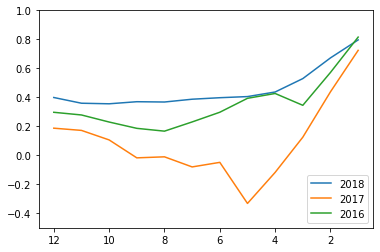

In [95]:
fig = plt.figure()
plt.plot(list(range(1,13)), r2_12_21_18, label = '2018')
plt.plot(list(range(1,13)), r2_12_21_17, label = '2017')
plt.plot(list(range(1,13)), r2_12_21_16, label = '2016')
plt.gca().invert_xaxis()
plt.ylim(-0.5,1)
plt.legend(loc=4)

In [100]:
def r2(obs_table, pred_tables,date):
    r2_list = []
    for i in pred_tables:
        nas = np.logical_or(np.isnan(obs_table[date].values), np.isnan(i[date].values))
        r2_date_pi = r2_score(list(obs_table[date][~nas]), list(i[date][~nas]))
        r2_list.append(r2_date_pi)
    return r2_list

In [106]:
r2_5_21_16_crop_rain = r2(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2016-05-21')
r2_5_21_17_crop_rain = r2(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2017-05-21')
r2_5_21_18_crop_rain = r2(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2018-05-21')
r2_5_21_11_crop_rain = r2(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2011-05-21')

In [116]:
r2_12_21_16_crop_rain = r2(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2016-12-21')
r2_12_21_17_crop_rain = r2(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2017-12-21')
r2_12_21_18_crop_rain = r2(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2018-12-21')
r2_12_21_11_crop_rain = r2(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2011-12-21')

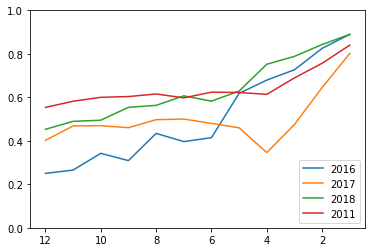

In [114]:
fig = plt.figure()
plt.plot(list(range(1,13)), r2_5_21_16_crop_rain, label = '2016')
plt.plot(list(range(1,13)), r2_5_21_17_crop_rain, label = '2017')
plt.plot(list(range(1,13)), r2_5_21_18_crop_rain, label = '2018')
plt.plot(list(range(1,13)), r2_5_21_11_crop_rain, label = '2011')
plt.gca().invert_xaxis()
plt.ylim(0,1)
plt.legend(loc=4)

In [112]:
r2_5_21_16_crop_irr = r2(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2016-05-21')
r2_5_21_17_crop_irr = r2(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2017-05-21')
r2_5_21_18_crop_irr = r2(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2018-05-21')
r2_5_21_11_crop_irr = r2(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2011-05-21')

In [123]:
r2_12_21_16_crop_irr = r2(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2016-12-21')
r2_12_21_17_crop_irr = r2(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2017-12-21')
r2_12_21_18_crop_irr = r2(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2018-12-21')
r2_12_21_11_crop_irr = r2(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2011-12-21')

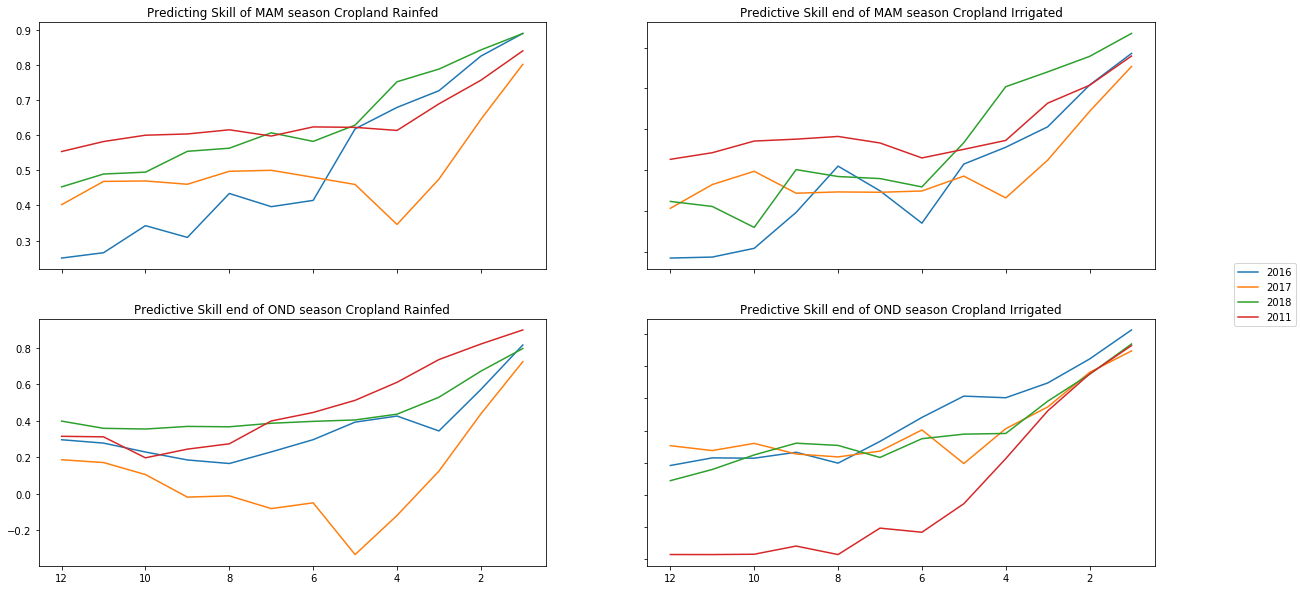

In [154]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20,10))

ax1.plot(list(range(1,13)), r2_5_21_16_crop_rain, label = '2016')
ax1.plot(list(range(1,13)), r2_5_21_17_crop_rain, label = '2017')
ax1.plot(list(range(1,13)), r2_5_21_18_crop_rain, label = '2018')
ax1.plot(list(range(1,13)), r2_5_21_11_crop_rain, label = '2011')
ax1.invert_xaxis()
ax1.set_title('Predicting Skill of MAM season Cropland Rainfed')
ax2.plot(list(range(1,13)), r2_5_21_16_crop_irr, label = '2016')
ax2.plot(list(range(1,13)), r2_5_21_17_crop_irr, label = '2017')
ax2.plot(list(range(1,13)), r2_5_21_18_crop_irr, label = '2018')
ax2.plot(list(range(1,13)), r2_5_21_11_crop_irr, label = '2011')
ax2.invert_xaxis()
ax2.set_title('Predictive Skill end of MAM season Cropland Irrigated')
ax3.plot(list(range(1,13)), r2_12_21_16_crop_rain, label = '2016')
ax3.plot(list(range(1,13)), r2_12_21_17_crop_rain, label = '2017')
ax3.plot(list(range(1,13)), r2_12_21_18_crop_rain, label = '2018')
ax3.plot(list(range(1,13)), r2_12_21_11_crop_rain, label = '2011')
ax3.invert_xaxis()
ax3.set_title('Predictive Skill end of OND season Cropland Rainfed')
ax4.plot(list(range(1,13)), r2_12_21_16_crop_irr, label = '2016')
ax4.plot(list(range(1,13)), r2_12_21_17_crop_irr, label = '2017')
ax4.plot(list(range(1,13)), r2_12_21_18_crop_irr, label = '2018')
ax4.plot(list(range(1,13)), r2_12_21_11_crop_irr, label = '2011')
ax4.invert_xaxis()
ax4.set_title('Predictive Skill end of OND season Cropland Irrigated')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='right')

for ax in fig.get_axes():
    ax.label_outer()

In [96]:
#ndvi_simplex_pi1_crop_rain.iloc[0,12::36]

In [145]:
r2_score(list(ndvi_table_lct_crop_rain.iloc[0,12::36]), list(ndvi_simplex_pi1_crop_rain.iloc[0,12::36]))

0.9504206552828295

In [149]:
nas_3681 = np.logical_or(np.isnan(ndvi_table_lct_crop_rain.iloc[0,:].values), np.isnan(ndvi_simplex_pi1_crop_rain.iloc[0,:].values))

In [151]:
r2_score(list(ndvi_table_lct_crop_rain.iloc[0, :][~nas_3681]), list(ndvi_simplex_pi1_crop_rain.iloc[0,:][~nas_3681]))

0.922988123959274

In [150]:
def r_sq(obs_table, pred_tables,date):
    r_sq_list = []
    for i in pred_tables:
        nas = np.logical_or(np.isnan(obs_table[date].values), np.isnan(i[date].values))
        r,p = stats.pearsonr(list(obs_table[date][~nas]), list(i[date][~nas]))
        r_sq = r**2
        r_sq_list.append(r_sq)
    return r_sq_list

In [155]:
r_sq_5_21_03_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2003-05-21')
r_sq_5_21_04_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2004-05-21')
r_sq_5_21_05_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2005-05-21')
r_sq_5_21_06_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2006-05-21')
r_sq_5_21_07_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2007-05-21')
r_sq_5_21_08_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2008-05-21')
r_sq_5_21_09_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2009-05-21')
r_sq_5_21_10_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2010-05-21')
r_sq_5_21_11_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2011-05-21')
r_sq_5_21_12_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2012-05-21')
r_sq_5_21_13_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2013-05-21')
r_sq_5_21_14_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2014-05-21')
r_sq_5_21_15_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2015-05-21')
r_sq_5_21_16_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2016-05-21')
r_sq_5_21_17_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2017-05-21')
r_sq_5_21_18_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2018-05-21')


In [156]:
r_sq_5_21_03_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2003-05-21')
r_sq_5_21_04_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2004-05-21')
r_sq_5_21_05_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2005-05-21')
r_sq_5_21_06_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2006-05-21')
r_sq_5_21_07_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2007-05-21')
r_sq_5_21_08_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2008-05-21')
r_sq_5_21_09_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2009-05-21')
r_sq_5_21_10_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2010-05-21')
r_sq_5_21_11_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2011-05-21')
r_sq_5_21_12_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2012-05-21')
r_sq_5_21_13_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2013-05-21')
r_sq_5_21_14_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2014-05-21')
r_sq_5_21_15_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2015-05-21')
r_sq_5_21_16_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2016-05-21')
r_sq_5_21_17_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2017-05-21')
r_sq_5_21_18_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2018-05-21')


In [157]:
r_sq_12_21_03_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2003-12-21')
r_sq_12_21_04_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2004-12-21')
r_sq_12_21_05_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2005-12-21')
r_sq_12_21_06_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2006-12-21')
r_sq_12_21_07_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2007-12-21')
r_sq_12_21_08_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2008-12-21')
r_sq_12_21_09_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2009-12-21')
r_sq_12_21_10_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2010-12-21')
r_sq_12_21_11_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2011-12-21')
r_sq_12_21_12_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2012-12-21')
r_sq_12_21_13_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2013-12-21')
r_sq_12_21_14_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2014-12-21')
r_sq_12_21_15_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2015-12-21')
r_sq_12_21_16_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2016-12-21')
r_sq_12_21_17_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2017-12-21')
r_sq_12_21_18_crop_irr = r_sq(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2018-12-21')


In [158]:
r_sq_12_21_03_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2003-12-21')
r_sq_12_21_04_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2004-12-21')
r_sq_12_21_05_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2005-12-21')
r_sq_12_21_06_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2006-12-21')
r_sq_12_21_07_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2007-12-21')
r_sq_12_21_08_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2008-12-21')
r_sq_12_21_09_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2009-12-21')
r_sq_12_21_10_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2010-12-21')
r_sq_12_21_11_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2011-12-21')
r_sq_12_21_12_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2012-12-21')
r_sq_12_21_13_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2013-12-21')
r_sq_12_21_14_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2014-12-21')
r_sq_12_21_15_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2015-12-21')
r_sq_12_21_16_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2016-12-21')
r_sq_12_21_17_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2017-12-21')
r_sq_12_21_18_crop_rain = r_sq(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2018-12-21')


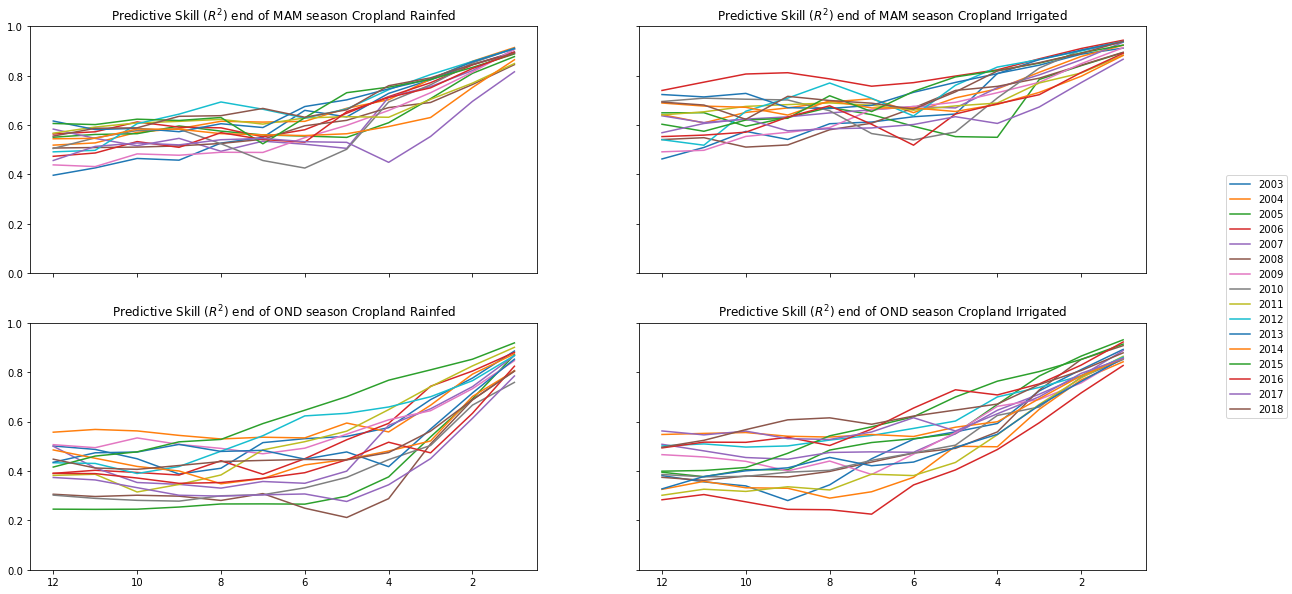

In [173]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20,10))

ax1.plot(list(range(1,13)), r_sq_5_21_03_crop_rain, label = '2003')
ax1.plot(list(range(1,13)), r_sq_5_21_04_crop_rain, label = '2004')
ax1.plot(list(range(1,13)), r_sq_5_21_05_crop_rain, label = '2005')
ax1.plot(list(range(1,13)), r_sq_5_21_06_crop_rain, label = '2006')
ax1.plot(list(range(1,13)), r_sq_5_21_07_crop_rain, label = '2007')
ax1.plot(list(range(1,13)), r_sq_5_21_08_crop_rain, label = '2008')
ax1.plot(list(range(1,13)), r_sq_5_21_09_crop_rain, label = '2009')
ax1.plot(list(range(1,13)), r_sq_5_21_10_crop_rain, label = '2010')
ax1.plot(list(range(1,13)), r_sq_5_21_11_crop_rain, label = '2011')
ax1.plot(list(range(1,13)), r_sq_5_21_12_crop_rain, label = '2012')
ax1.plot(list(range(1,13)), r_sq_5_21_13_crop_rain, label = '2013')
ax1.plot(list(range(1,13)), r_sq_5_21_14_crop_rain, label = '2014')
ax1.plot(list(range(1,13)), r_sq_5_21_15_crop_rain, label = '2015')
ax1.plot(list(range(1,13)), r_sq_5_21_16_crop_rain, label = '2016')
ax1.plot(list(range(1,13)), r_sq_5_21_17_crop_rain, label = '2017')
ax1.plot(list(range(1,13)), r_sq_5_21_18_crop_rain, label = '2018')
ax1.invert_xaxis()
ax1.set_title('Predictive Skill ($R^2$) end of MAM season Cropland Rainfed')
ax1.set_ylim(0,1)

ax2.plot(list(range(1,13)), r_sq_5_21_03_crop_irr, label = '2003')
ax2.plot(list(range(1,13)), r_sq_5_21_04_crop_irr, label = '2004')
ax2.plot(list(range(1,13)), r_sq_5_21_05_crop_irr, label = '2005')
ax2.plot(list(range(1,13)), r_sq_5_21_06_crop_irr, label = '2006')
ax2.plot(list(range(1,13)), r_sq_5_21_07_crop_irr, label = '2007')
ax2.plot(list(range(1,13)), r_sq_5_21_08_crop_irr, label = '2008')
ax2.plot(list(range(1,13)), r_sq_5_21_09_crop_irr, label = '2009')
ax2.plot(list(range(1,13)), r_sq_5_21_10_crop_irr, label = '2010')
ax2.plot(list(range(1,13)), r_sq_5_21_11_crop_irr, label = '2011')
ax2.plot(list(range(1,13)), r_sq_5_21_12_crop_irr, label = '2012')
ax2.plot(list(range(1,13)), r_sq_5_21_13_crop_irr, label = '2013')
ax2.plot(list(range(1,13)), r_sq_5_21_14_crop_irr, label = '2014')
ax2.plot(list(range(1,13)), r_sq_5_21_15_crop_irr, label = '2015')
ax2.plot(list(range(1,13)), r_sq_5_21_16_crop_irr, label = '2016')
ax2.plot(list(range(1,13)), r_sq_5_21_17_crop_irr, label = '2017')
ax2.plot(list(range(1,13)), r_sq_5_21_18_crop_irr, label = '2018')
ax2.invert_xaxis()
ax2.set_title('Predictive Skill ($R^2$) end of MAM season Cropland Irrigated')
ax2.set_ylim(0,1)

ax3.plot(list(range(1,13)), r_sq_12_21_03_crop_rain, label = '2003')
ax3.plot(list(range(1,13)), r_sq_12_21_04_crop_rain, label = '2004')
ax3.plot(list(range(1,13)), r_sq_12_21_05_crop_rain, label = '2005')
ax3.plot(list(range(1,13)), r_sq_12_21_06_crop_rain, label = '2006')
ax3.plot(list(range(1,13)), r_sq_12_21_07_crop_rain, label = '2007')
ax3.plot(list(range(1,13)), r_sq_12_21_08_crop_rain, label = '2008')
ax3.plot(list(range(1,13)), r_sq_12_21_09_crop_rain, label = '2009')
ax3.plot(list(range(1,13)), r_sq_12_21_10_crop_rain, label = '2010')
ax3.plot(list(range(1,13)), r_sq_12_21_11_crop_rain, label = '2011')
ax3.plot(list(range(1,13)), r_sq_12_21_12_crop_rain, label = '2012')
ax3.plot(list(range(1,13)), r_sq_12_21_13_crop_rain, label = '2013')
ax3.plot(list(range(1,13)), r_sq_12_21_14_crop_rain, label = '2014')
ax3.plot(list(range(1,13)), r_sq_12_21_15_crop_rain, label = '2015')
ax3.plot(list(range(1,13)), r_sq_12_21_16_crop_rain, label = '2016')
ax3.plot(list(range(1,13)), r_sq_12_21_17_crop_rain, label = '2017')
ax3.plot(list(range(1,13)), r_sq_12_21_18_crop_rain, label = '2018')
ax3.invert_xaxis()
ax3.set_title('Predictive Skill ($R^2$) end of OND season Cropland Rainfed')
ax3.set_ylim(0,1)

ax4.plot(list(range(1,13)), r_sq_12_21_03_crop_irr, label = '2003')
ax4.plot(list(range(1,13)), r_sq_12_21_04_crop_irr, label = '2004')
ax4.plot(list(range(1,13)), r_sq_12_21_05_crop_irr, label = '2005')
ax4.plot(list(range(1,13)), r_sq_12_21_06_crop_irr, label = '2006')
ax4.plot(list(range(1,13)), r_sq_12_21_07_crop_irr, label = '2007')
ax4.plot(list(range(1,13)), r_sq_12_21_08_crop_irr, label = '2008')
ax4.plot(list(range(1,13)), r_sq_12_21_09_crop_irr, label = '2009')
ax4.plot(list(range(1,13)), r_sq_12_21_10_crop_irr, label = '2010')
ax4.plot(list(range(1,13)), r_sq_12_21_11_crop_irr, label = '2011')
ax4.plot(list(range(1,13)), r_sq_12_21_12_crop_irr, label = '2012')
ax4.plot(list(range(1,13)), r_sq_12_21_13_crop_irr, label = '2013')
ax4.plot(list(range(1,13)), r_sq_12_21_14_crop_irr, label = '2014')
ax4.plot(list(range(1,13)), r_sq_12_21_15_crop_irr, label = '2015')
ax4.plot(list(range(1,13)), r_sq_12_21_16_crop_irr, label = '2016')
ax4.plot(list(range(1,13)), r_sq_12_21_17_crop_irr, label = '2017')
ax4.plot(list(range(1,13)), r_sq_12_21_18_crop_irr, label = '2018')
ax4.invert_xaxis()
ax4.set_title('Predictive Skill ($R^2$) end of OND season Cropland Irrigated')
ax4.set_ylim(0,1)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='right')


for ax in fig.get_axes():
    ax.label_outer()

In [37]:
def pearsonr(obs_table, pred_tables,date):
    pearsonr_list = []
    for i in pred_tables:
        nas = np.logical_or(np.isnan(obs_table[date].values), np.isnan(i[date].values))
        r,p = stats.pearsonr(list(obs_table[date][~nas]), list(i[date][~nas]))
        pearsonr_list.append(r)
    return pearsonr_list

In [38]:
rho_5_21_03_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2003-05-21')
rho_5_21_04_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2004-05-21')
rho_5_21_05_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2005-05-21')
rho_5_21_06_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2006-05-21')
rho_5_21_07_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2007-05-21')
rho_5_21_08_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2008-05-21')
rho_5_21_09_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2009-05-21')
rho_5_21_10_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2010-05-21')
rho_5_21_11_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2011-05-21')
rho_5_21_12_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2012-05-21')
rho_5_21_13_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2013-05-21')
rho_5_21_14_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2014-05-21')
rho_5_21_15_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2015-05-21')
rho_5_21_16_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2016-05-21')
rho_5_21_17_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2017-05-21')
rho_5_21_18_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2018-05-21')


In [39]:
rho_5_21_03_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2003-05-21')
rho_5_21_04_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2004-05-21')
rho_5_21_05_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2005-05-21')
rho_5_21_06_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2006-05-21')
rho_5_21_07_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2007-05-21')
rho_5_21_08_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2008-05-21')
rho_5_21_09_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2009-05-21')
rho_5_21_10_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2010-05-21')
rho_5_21_11_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2011-05-21')
rho_5_21_12_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2012-05-21')
rho_5_21_13_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2013-05-21')
rho_5_21_14_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2014-05-21')
rho_5_21_15_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2015-05-21')
rho_5_21_16_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2016-05-21')
rho_5_21_17_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2017-05-21')
rho_5_21_18_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2018-05-21')


In [40]:
rho_12_21_03_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2003-12-21')
rho_12_21_04_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2004-12-21')
rho_12_21_05_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2005-12-21')
rho_12_21_06_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2006-12-21')
rho_12_21_07_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2007-12-21')
rho_12_21_08_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2008-12-21')
rho_12_21_09_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2009-12-21')
rho_12_21_10_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2010-12-21')
rho_12_21_11_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2011-12-21')
rho_12_21_12_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2012-12-21')
rho_12_21_13_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2013-12-21')
rho_12_21_14_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2014-12-21')
rho_12_21_15_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2015-12-21')
rho_12_21_16_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2016-12-21')
rho_12_21_17_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2017-12-21')
rho_12_21_18_crop_irr = pearsonr(ndvi_table_lct_crop_irr, ndvi_pred_tables_crop_irr, '2018-12-21')


In [41]:
rho_12_21_03_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2003-12-21')
rho_12_21_04_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2004-12-21')
rho_12_21_05_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2005-12-21')
rho_12_21_06_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2006-12-21')
rho_12_21_07_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2007-12-21')
rho_12_21_08_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2008-12-21')
rho_12_21_09_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2009-12-21')
rho_12_21_10_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2010-12-21')
rho_12_21_11_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2011-12-21')
rho_12_21_12_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2012-12-21')
rho_12_21_13_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2013-12-21')
rho_12_21_14_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2014-12-21')
rho_12_21_15_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2015-12-21')
rho_12_21_16_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2016-12-21')
rho_12_21_17_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2017-12-21')
rho_12_21_18_crop_rain = pearsonr(ndvi_table_lct_crop_rain, ndvi_pred_tables_crop_rain, '2018-12-21')


In [110]:
rho_5_21_03_crop_rain

[0.9504990068296503,
 0.930492588131042,
 0.8978956197755016,
 0.8632209903355886,
 0.8034135384613277,
 0.8244770724575909,
 0.745144778580798,
 0.7257869200730562,
 0.6724044918296443,
 0.6746602191819518,
 0.6432286232226446,
 0.6160317949542906]

Text(0.1, 0.5, 'Predictive Skill (ρ)')

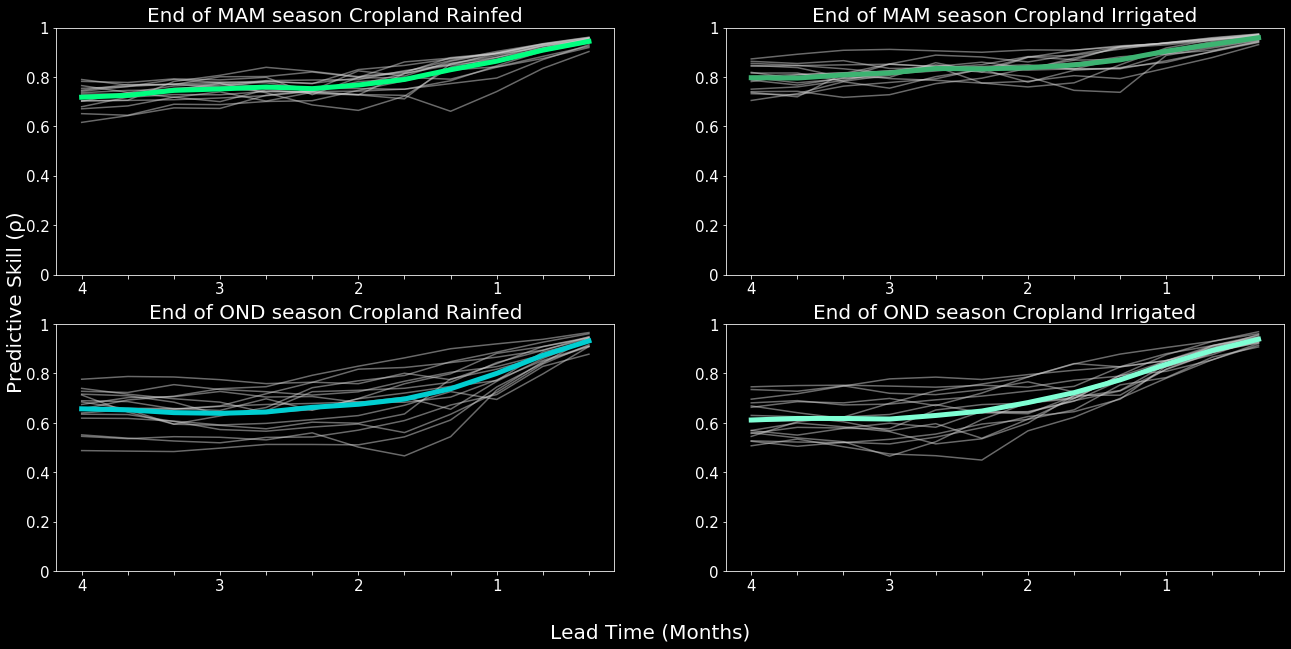

In [97]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (22,10))

ax1.plot(list(range(1,13)), rho_5_21_03_crop_rain, label = '2003', c = 'lightgray', alpha = 0.5)
ax1.plot(list(range(1,13)), rho_5_21_04_crop_rain, label = '2004', c = 'lightgray', alpha = 0.5)
ax1.plot(list(range(1,13)), rho_5_21_05_crop_rain, label = '2005', c = 'lightgray', alpha = 0.5)
ax1.plot(list(range(1,13)), rho_5_21_06_crop_rain, label = '2006', c = 'lightgray', alpha = 0.5)
ax1.plot(list(range(1,13)), rho_5_21_07_crop_rain, label = '2007', c = 'lightgray', alpha = 0.5)
ax1.plot(list(range(1,13)), rho_5_21_08_crop_rain, label = '2008', c = 'lightgray', alpha = 0.5)
ax1.plot(list(range(1,13)), rho_5_21_09_crop_rain, label = '2009', c = 'lightgray', alpha = 0.5)
ax1.plot(list(range(1,13)), rho_5_21_10_crop_rain, label = '2010', c = 'lightgray', alpha = 0.5)
ax1.plot(list(range(1,13)), rho_5_21_11_crop_rain, label = '2011', c = 'lightgray', alpha = 0.5)
ax1.plot(list(range(1,13)), rho_5_21_12_crop_rain, label = '2012', c = 'lightgray', alpha = 0.5)
ax1.plot(list(range(1,13)), rho_5_21_13_crop_rain, label = '2013', c = 'lightgray', alpha = 0.5)
ax1.plot(list(range(1,13)), rho_5_21_14_crop_rain, label = '2014', c = 'lightgray', alpha = 0.5)
ax1.plot(list(range(1,13)), rho_5_21_15_crop_rain, label = '2015', c = 'lightgray', alpha = 0.5)
ax1.plot(list(range(1,13)), rho_5_21_16_crop_rain, label = '2016', c = 'lightgray', alpha = 0.5)
ax1.plot(list(range(1,13)), rho_5_21_17_crop_rain, label = '2017', c = 'lightgray', alpha = 0.5)
ax1.plot(list(range(1,13)), rho_5_21_18_crop_rain, label = '2018', c = 'lightgray', alpha = 0.5)
ax1.invert_xaxis()
ax1.set_title('End of MAM season Cropland Rainfed', fontsize = 20)
ax1.set_ylim(0,1)
ax1.set_xticks(np.arange(1, 13, 1))
ax1.set_xticklabels(['','',1,'','',2,'','',3,'','',4], fontsize = 15)
ax1.set_yticklabels([0,0.2, 0.4, 0.6, 0.8, 1],fontsize=15)


ax2.plot(list(range(1,13)), rho_5_21_03_crop_irr, label = '2003', c = 'lightgray', alpha = 0.5)
ax2.plot(list(range(1,13)), rho_5_21_04_crop_irr, label = '2004', c = 'lightgray', alpha = 0.5)
ax2.plot(list(range(1,13)), rho_5_21_05_crop_irr, label = '2005', c = 'lightgray', alpha = 0.5)
ax2.plot(list(range(1,13)), rho_5_21_06_crop_irr, label = '2006', c = 'lightgray', alpha = 0.5)
ax2.plot(list(range(1,13)), rho_5_21_07_crop_irr, label = '2007', c = 'lightgray', alpha = 0.5)
ax2.plot(list(range(1,13)), rho_5_21_08_crop_irr, label = '2008', c = 'lightgray', alpha = 0.5)
ax2.plot(list(range(1,13)), rho_5_21_09_crop_irr, label = '2009', c = 'lightgray', alpha = 0.5)
ax2.plot(list(range(1,13)), rho_5_21_10_crop_irr, label = '2010', c = 'lightgray', alpha = 0.5)
ax2.plot(list(range(1,13)), rho_5_21_11_crop_irr, label = '2011', c = 'lightgray', alpha = 0.5)
ax2.plot(list(range(1,13)), rho_5_21_12_crop_irr, label = '2012', c = 'lightgray', alpha = 0.5)
ax2.plot(list(range(1,13)), rho_5_21_13_crop_irr, label = '2013', c = 'lightgray', alpha = 0.5)
ax2.plot(list(range(1,13)), rho_5_21_14_crop_irr, label = '2014', c = 'lightgray', alpha = 0.5)
ax2.plot(list(range(1,13)), rho_5_21_15_crop_irr, label = '2015', c = 'lightgray', alpha = 0.5)
ax2.plot(list(range(1,13)), rho_5_21_16_crop_irr, label = '2016', c = 'lightgray', alpha = 0.5)
ax2.plot(list(range(1,13)), rho_5_21_17_crop_irr, label = '2017', c = 'lightgray', alpha = 0.5)
ax2.plot(list(range(1,13)), rho_5_21_18_crop_irr, label = '2018', c = 'lightgray', alpha = 0.5)
ax2.invert_xaxis()
ax2.set_title('End of MAM season Cropland Irrigated', fontsize = 20)
ax2.set_ylim(0,1)
ax2.set_xticks(np.arange(1, 13, 1))
ax2.set_xticklabels(['','',1,'','',2,'','',3,'','',4], fontsize = 15)
ax2.set_yticklabels([0,0.2, 0.4, 0.6, 0.8, 1],fontsize=15)

ax3.plot(list(range(1,13)), rho_12_21_03_crop_rain, label = '2003', c = 'lightgray', alpha = 0.5)
ax3.plot(list(range(1,13)), rho_12_21_04_crop_rain, label = '2004', c = 'lightgray', alpha = 0.5)
ax3.plot(list(range(1,13)), rho_12_21_05_crop_rain, label = '2005', c = 'lightgray', alpha = 0.5)
ax3.plot(list(range(1,13)), rho_12_21_06_crop_rain, label = '2006', c = 'lightgray', alpha = 0.5)
ax3.plot(list(range(1,13)), rho_12_21_07_crop_rain, label = '2007', c = 'lightgray', alpha = 0.5)
ax3.plot(list(range(1,13)), rho_12_21_08_crop_rain, label = '2008', c = 'lightgray', alpha = 0.5)
ax3.plot(list(range(1,13)), rho_12_21_09_crop_rain, label = '2009', c = 'lightgray', alpha = 0.5)
ax3.plot(list(range(1,13)), rho_12_21_10_crop_rain, label = '2010', c = 'lightgray', alpha = 0.5)
ax3.plot(list(range(1,13)), rho_12_21_11_crop_rain, label = '2011', c = 'lightgray', alpha = 0.5)
ax3.plot(list(range(1,13)), rho_12_21_12_crop_rain, label = '2012', c = 'lightgray', alpha = 0.5)
ax3.plot(list(range(1,13)), rho_12_21_13_crop_rain, label = '2013', c = 'lightgray', alpha = 0.5)
ax3.plot(list(range(1,13)), rho_12_21_14_crop_rain, label = '2014', c = 'lightgray', alpha = 0.5)
ax3.plot(list(range(1,13)), rho_12_21_15_crop_rain, label = '2015', c = 'lightgray', alpha = 0.5)
ax3.plot(list(range(1,13)), rho_12_21_16_crop_rain, label = '2016', c = 'lightgray', alpha = 0.5)
ax3.plot(list(range(1,13)), rho_12_21_17_crop_rain, label = '2017', c = 'lightgray', alpha = 0.5)
ax3.plot(list(range(1,13)), rho_12_21_18_crop_rain, label = '2018', c = 'lightgray', alpha = 0.5)
ax3.invert_xaxis()
ax3.set_title('End of OND season Cropland Rainfed', fontsize = 20)
ax3.set_ylim(0,1)
ax3.set_xticks(np.arange(1, 13, 1))
ax3.set_xticklabels(['','',1,'','',2,'','',3,'','',4], fontsize = 15)
ax3.set_yticklabels([0,0.2, 0.4, 0.6, 0.8, 1],fontsize=15)

ax4.plot(list(range(1,13)), rho_12_21_03_crop_irr, label = '2003', c = 'lightgray', alpha = 0.5)
ax4.plot(list(range(1,13)), rho_12_21_04_crop_irr, label = '2004', c = 'lightgray', alpha = 0.5)
ax4.plot(list(range(1,13)), rho_12_21_05_crop_irr, label = '2005', c = 'lightgray', alpha = 0.5)
ax4.plot(list(range(1,13)), rho_12_21_06_crop_irr, label = '2006', c = 'lightgray', alpha = 0.5)
ax4.plot(list(range(1,13)), rho_12_21_07_crop_irr, label = '2007', c = 'lightgray', alpha = 0.5)
ax4.plot(list(range(1,13)), rho_12_21_08_crop_irr, label = '2008', c = 'lightgray', alpha = 0.5)
ax4.plot(list(range(1,13)), rho_12_21_09_crop_irr, label = '2009', c = 'lightgray', alpha = 0.5)
ax4.plot(list(range(1,13)), rho_12_21_10_crop_irr, label = '2010', c = 'lightgray', alpha = 0.5)
ax4.plot(list(range(1,13)), rho_12_21_11_crop_irr, label = '2011', c = 'lightgray', alpha = 0.5)
ax4.plot(list(range(1,13)), rho_12_21_12_crop_irr, label = '2012', c = 'lightgray', alpha = 0.5)
ax4.plot(list(range(1,13)), rho_12_21_13_crop_irr, label = '2013', c = 'lightgray', alpha = 0.5)
ax4.plot(list(range(1,13)), rho_12_21_14_crop_irr, label = '2014', c = 'lightgray', alpha = 0.5)
ax4.plot(list(range(1,13)), rho_12_21_15_crop_irr, label = '2015', c = 'lightgray', alpha = 0.5)
ax4.plot(list(range(1,13)), rho_12_21_16_crop_irr, label = '2016', c = 'lightgray', alpha = 0.5)
ax4.plot(list(range(1,13)), rho_12_21_17_crop_irr, label = '2017', c = 'lightgray', alpha = 0.5)
ax4.plot(list(range(1,13)), rho_12_21_18_crop_irr, label = '2018', c = 'lightgray', alpha = 0.5)
ax4.invert_xaxis()
ax4.set_title('End of OND season Cropland Irrigated', fontsize = 20)
ax4.set_ylim(0,1)
ax4.set_xticks(np.arange(1, 13, 1))
ax4.set_xticklabels(['','',1,'','',2,'','',3,'','',4], fontsize = 15)
ax4.set_yticklabels([0,0.2, 0.4, 0.6, 0.8, 1],fontsize=15)

# handles, labels = ax1.get_legend_handles_labels()
# fig.legend(handles, labels, loc='right')


# for ax in fig.get_axes():
#     ax.label_outer()

ax1.plot(list(range(1,13)), rho_5_21_crop_rain['mean'], label = 'MAM Rainfed', c = 'springgreen', linewidth = 5)
ax2.plot(list(range(1,13)), rho_5_21_crop_irr['mean'], label = 'MAM Irrigated', c = 'mediumseagreen', linewidth = 5)
ax3.plot(list(range(1,13)), rho_12_21_crop_rain['mean'], label = 'OND Rainfed', c = 'darkturquoise', linewidth = 5)
ax4.plot(list(range(1,13)), rho_12_21_crop_irr['mean'], label = 'OND Irrigated', c = 'aquamarine', linewidth = 5)

    
fig.text(0.5,0.04, 'Lead Time (Months)', ha="center", va="center", fontsize = 20)
fig.text(0.1,0.5, 'Predictive Skill (ρ)', ha="center", va="center", rotation=90, fontsize = 20)


In [64]:
list(range(1,13))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [65]:
np.arange(1, 13, 1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [104]:
dates_2003 = [col for col in precip_table_crop_rain if col.startswith('2003')]
dates_2004 = [col for col in precip_table_crop_rain if col.startswith('2004')]
dates_2005 = [col for col in precip_table_crop_rain if col.startswith('2005')]
dates_2006 = [col for col in precip_table_crop_rain if col.startswith('2006')]
dates_2007 = [col for col in precip_table_crop_rain if col.startswith('2007')]
dates_2008 = [col for col in precip_table_crop_rain if col.startswith('2008')]
dates_2009 = [col for col in precip_table_crop_rain if col.startswith('2009')]
dates_2010 = [col for col in precip_table_crop_rain if col.startswith('2010')]
dates_2011 = [col for col in precip_table_crop_rain if col.startswith('2011')]
dates_2012 = [col for col in precip_table_crop_rain if col.startswith('2012')]
dates_2013 = [col for col in precip_table_crop_rain if col.startswith('2013')]
dates_2014 = [col for col in precip_table_crop_rain if col.startswith('2014')]
dates_2015 = [col for col in precip_table_crop_rain if col.startswith('2015')]
dates_2016 = [col for col in precip_table_crop_rain if col.startswith('2016')]
dates_2017 = [col for col in precip_table_crop_rain if col.startswith('2017')]
dates_2018 = [col for col in precip_table_crop_rain if col.startswith('2018')]

NameError: name 'precip_table_crop_rain' is not defined

In [237]:
dates_2003_ond = [col for col in precip_table_crop_rain if col.startswith(('2003-10','2003-11','2003-12'))]
dates_2004_ond = [col for col in precip_table_crop_rain if col.startswith(('2004-10','2004-11','2004-12'))]
dates_2005_ond = [col for col in precip_table_crop_rain if col.startswith(('2005-10','2005-11','2005-12'))]
dates_2006_ond = [col for col in precip_table_crop_rain if col.startswith(('2006-10','2006-11','2006-12'))]
dates_2007_ond = [col for col in precip_table_crop_rain if col.startswith(('2007-10','2007-11','2007-12'))]
dates_2008_ond = [col for col in precip_table_crop_rain if col.startswith(('2008-10','2008-11','2008-12'))]
dates_2009_ond = [col for col in precip_table_crop_rain if col.startswith(('2009-10','2009-11','2009-12'))]
dates_2010_ond = [col for col in precip_table_crop_rain if col.startswith(('2010-10','2010-11','2010-12'))]
dates_2011_ond = [col for col in precip_table_crop_rain if col.startswith(('2011-10','2011-11','2011-12'))]
dates_2012_ond = [col for col in precip_table_crop_rain if col.startswith(('2012-10','2012-11','2012-12'))]
dates_2013_ond = [col for col in precip_table_crop_rain if col.startswith(('2013-10','2013-11','2013-12'))]
dates_2014_ond = [col for col in precip_table_crop_rain if col.startswith(('2014-10','2014-11','2014-12'))]
dates_2015_ond = [col for col in precip_table_crop_rain if col.startswith(('2015-10','2015-11','2015-12'))]
dates_2016_ond = [col for col in precip_table_crop_rain if col.startswith(('2016-10','2016-11','2016-12'))]
dates_2017_ond = [col for col in precip_table_crop_rain if col.startswith(('2017-10','2017-11','2017-12'))]
dates_2018_ond = [col for col in precip_table_crop_rain if col.startswith(('2018-10','2018-11','2018-12'))]

In [230]:
print('2003', precip_table_crop_rain[dates_2003].mean(1).mean())
print('2004', precip_table_crop_rain[dates_2004].mean(1).mean())
print('2005', precip_table_crop_rain[dates_2005].mean(1).mean())
print('2006', precip_table_crop_rain[dates_2006].mean(1).mean())
print('2007', precip_table_crop_rain[dates_2007].mean(1).mean())
print('2008', precip_table_crop_rain[dates_2008].mean(1).mean())
print('2009', precip_table_crop_rain[dates_2009].mean(1).mean())
print('2010', precip_table_crop_rain[dates_2010].mean(1).mean())
print('2011', precip_table_crop_rain[dates_2011].mean(1).mean())
print('2012', precip_table_crop_rain[dates_2012].mean(1).mean())
print('2013', precip_table_crop_rain[dates_2013].mean(1).mean())
print('2014', precip_table_crop_rain[dates_2014].mean(1).mean())
print('2015', precip_table_crop_rain[dates_2015].mean(1).mean())
print('2016', precip_table_crop_rain[dates_2016].mean(1).mean())
print('2017', precip_table_crop_rain[dates_2017].mean(1).mean())
print('2018', precip_table_crop_rain[dates_2018].mean(1).mean())

2003 -0.0034797607449827983
2004 -0.08095885111285499
2005 -0.08626632513738723
2006 0.09850727762218622
2007 0.026054539160852683
2008 -0.07434313425630022
2009 -0.10577702474173419
2010 0.03934919856474851
2011 0.034644868833634275
2012 0.059455605367923554
2013 0.0044724996472908785
2014 0.00996763882559969
2015 -0.010442474662967924
2016 -0.02913113474875502
2017 0.010558535796003823
2018 0.13865496238204292


In [238]:
print('2003', precip_table_crop_rain[dates_2003_ond].mean(1).mean())
print('2004', precip_table_crop_rain[dates_2004_ond].mean(1).mean())
print('2005', precip_table_crop_rain[dates_2005_ond].mean(1).mean())
print('2006', precip_table_crop_rain[dates_2006_ond].mean(1).mean())
print('2007', precip_table_crop_rain[dates_2007_ond].mean(1).mean())
print('2008', precip_table_crop_rain[dates_2008_ond].mean(1).mean())
print('2009', precip_table_crop_rain[dates_2009_ond].mean(1).mean())
print('2010', precip_table_crop_rain[dates_2010_ond].mean(1).mean())
print('2011', precip_table_crop_rain[dates_2011_ond].mean(1).mean())
print('2012', precip_table_crop_rain[dates_2012_ond].mean(1).mean())
print('2013', precip_table_crop_rain[dates_2013_ond].mean(1).mean())
print('2014', precip_table_crop_rain[dates_2014_ond].mean(1).mean())
print('2015', precip_table_crop_rain[dates_2015_ond].mean(1).mean())
print('2016', precip_table_crop_rain[dates_2016_ond].mean(1).mean())
print('2017', precip_table_crop_rain[dates_2017_ond].mean(1).mean())
print('2018', precip_table_crop_rain[dates_2018_ond].mean(1).mean())

2003 -0.27894391207481634
2004 -0.1485838863340382
2005 -0.42767695031922015
2006 0.14530718182185018
2007 -0.31447975502159886
2008 -0.28342389587281114
2009 -0.12300304992037125
2010 -0.2123857529570232
2011 0.011062926854645784
2012 -0.04093235462630272
2013 -0.18343991861998246
2014 -0.15784415612506938
2015 0.016803109062317436
2016 -0.30438211312187846
2017 -0.24994586964083215
2018 -0.12426025637713378


In [239]:
rho_5_21_03_crop_irr

[0.9546315155751014,
 0.9416087273938655,
 0.9177899489378561,
 0.8992771895174596,
 0.8028260982007778,
 0.7959808775319854,
 0.782350338872993,
 0.7780328863471317,
 0.7359731345640086,
 0.7578576779733455,
 0.7136377857500046,
 0.6802607546723101]

In [71]:
rho_5_21_crop_irr = pd.DataFrame(list(zip(rho_5_21_03_crop_irr, 
                      rho_5_21_04_crop_irr, 
                      rho_5_21_05_crop_irr, 
                      rho_5_21_06_crop_irr, 
                      rho_5_21_07_crop_irr, 
                      rho_5_21_08_crop_irr, 
                      rho_5_21_09_crop_irr, 
                      rho_5_21_10_crop_irr,
                      rho_5_21_11_crop_irr,
                     rho_5_21_12_crop_irr,
                     rho_5_21_13_crop_irr,
                      rho_5_21_14_crop_irr,
                     rho_5_21_15_crop_irr,
                     rho_5_21_16_crop_irr,
                     rho_5_21_17_crop_irr,
                     rho_5_21_18_crop_irr)), 
               columns =['2003', '2004', '2005','2006','2007','2008','2009','2010','2011', '2012', '2013', '2014','2015','2016','2017','2018']) 

In [72]:
rho_5_21_crop_rain = pd.DataFrame(list(zip(rho_5_21_03_crop_rain, 
                      rho_5_21_04_crop_rain, 
                      rho_5_21_05_crop_rain, 
                      rho_5_21_06_crop_rain, 
                      rho_5_21_07_crop_rain, 
                      rho_5_21_08_crop_rain, 
                      rho_5_21_09_crop_rain, 
                      rho_5_21_10_crop_rain,
                      rho_5_21_11_crop_rain,
                     rho_5_21_12_crop_rain,
                     rho_5_21_13_crop_rain,
                      rho_5_21_14_crop_rain,
                     rho_5_21_15_crop_rain,
                     rho_5_21_16_crop_rain,
                     rho_5_21_17_crop_rain,
                     rho_5_21_18_crop_rain)), 
               columns =['2003', '2004', '2005','2006','2007','2008','2009','2010','2011', '2012', '2013', '2014','2015','2016','2017','2018']) 

In [73]:
rho_12_21_crop_irr = pd.DataFrame(list(zip(rho_12_21_03_crop_irr, 
                      rho_12_21_04_crop_irr, 
                      rho_12_21_05_crop_irr, 
                      rho_12_21_06_crop_irr, 
                      rho_12_21_07_crop_irr, 
                      rho_12_21_08_crop_irr, 
                      rho_12_21_09_crop_irr, 
                      rho_12_21_10_crop_irr,
                      rho_12_21_11_crop_irr,
                     rho_12_21_12_crop_irr,
                     rho_12_21_13_crop_irr,
                      rho_12_21_14_crop_irr,
                     rho_12_21_15_crop_irr,
                     rho_12_21_16_crop_irr,
                     rho_12_21_17_crop_irr,
                     rho_12_21_18_crop_irr)), 
               columns =['2003', '2004', '2005','2006','2007','2008','2009','2010','2011', '2012', '2013', '2014','2015','2016','2017','2018']) 

In [74]:
rho_12_21_crop_rain = pd.DataFrame(list(zip(rho_12_21_03_crop_rain, 
                      rho_12_21_04_crop_rain, 
                      rho_12_21_05_crop_rain, 
                      rho_12_21_06_crop_rain, 
                      rho_12_21_07_crop_rain, 
                      rho_12_21_08_crop_rain, 
                      rho_12_21_09_crop_rain, 
                      rho_12_21_10_crop_rain,
                      rho_12_21_11_crop_rain,
                     rho_12_21_12_crop_rain,
                     rho_12_21_13_crop_rain,
                      rho_12_21_14_crop_rain,
                     rho_12_21_15_crop_rain,
                     rho_12_21_16_crop_rain,
                     rho_12_21_17_crop_rain,
                     rho_12_21_18_crop_rain)), 
               columns =['2003', '2004', '2005','2006','2007','2008','2009','2010','2011', '2012', '2013', '2014','2015','2016','2017','2018']) 

In [75]:
rho_5_21_crop_irr['mean'] = rho_5_21_crop_irr.mean(1)
rho_5_21_crop_rain['mean'] = rho_5_21_crop_rain.mean(1)
rho_12_21_crop_irr['mean'] = rho_12_21_crop_irr.mean(1)
rho_12_21_crop_rain['mean'] = rho_12_21_crop_rain.mean(1)

In [260]:
rho_5_21_crop_irr['mean']

0     0.955486
1     0.926758
2     0.895128
3     0.858316
4     0.829993
5     0.806321
6     0.808980
7     0.818500
8     0.802412
9     0.796881
10    0.784646
11    0.783771
Name: mean, dtype: float64

Text(0, 0.5, 'Predictive Skill (ρ)')

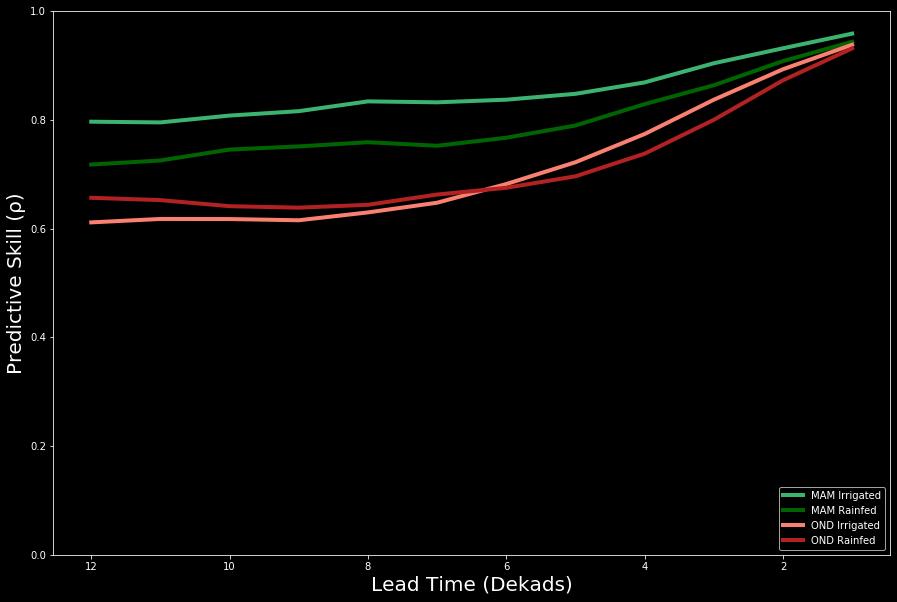

In [76]:
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(list(range(1,13)), rho_5_21_crop_irr['mean'], label = 'MAM Irrigated', c = 'mediumseagreen', linewidth = 4)
ax.plot(list(range(1,13)), rho_5_21_crop_rain['mean'], label = 'MAM Rainfed', c = 'darkgreen', linewidth = 4)
ax.plot(list(range(1,13)), rho_12_21_crop_irr['mean'], label = 'OND Irrigated', c = 'salmon', linewidth = 4)
ax.plot(list(range(1,13)), rho_12_21_crop_rain['mean'], label = 'OND Rainfed', c = 'firebrick', linewidth = 4)
ax.invert_xaxis()
ax.set_ylim(0,1)
ax.legend(loc=4)
ax.set_xlabel('Lead Time (Dekads)', fontsize = 20)
ax.set_ylabel('Predictive Skill (ρ)', fontsize = 20)

In [104]:
ndvi_table_lct_crop_rain['2003-05-21']

3681      0.327721
41006    -1.301580
51543    -1.437599
52208    -1.268950
53372    -0.815143
            ...   
382709    0.400071
383868    1.053530
383942    0.142862
385086    0.355001
387421    0.302379
Name: 2003-05-21, Length: 20820, dtype: float64

In [108]:
ndvi_simplex_pi6T_crop_rain

,2002-08-21,2002-09-01,2002-09-11,2002-09-21,2002-10-01,2002-10-11,2002-10-21,2002-11-01,2002-11-11,2002-11-21,...,2019-03-11,2019-03-21,2019-04-01,2019-04-11,2019-04-21,2019-05-01,2019-05-11,2019-05-21,2019-06-01,2019-06-11
pixel_id,,,,,,,,,,,,,,,,,,,,,
3681,NaN,NaN,NaN,NaN,NaN,NaN,-0.881364,-0.619998,-1.028437,-1.055949,...,-0.975216,-0.858422,-0.698006,-0.441624,-0.545178,-0.550445,-0.173919,0.227415,0.459313,-0.150588
41006,NaN,NaN,NaN,NaN,NaN,NaN,-0.897086,-0.640542,-0.533953,-0.551528,...,1.680940,1.478263,1.395307,1.294104,1.016466,1.043204,1.007112,0.820831,0.963102,0.957612
51543,NaN,NaN,NaN,NaN,NaN,NaN,-1.089770,-0.928150,-0.775001,-0.895398,...,1.057988,1.023268,0.914808,0.703428,0.611179,0.603778,0.578788,0.551060,0.455785,0.520369
52208,NaN,NaN,NaN,NaN,NaN,NaN,1.303100,0.980612,0.706145,0.491306,...,-0.598910,-0.655550,-0.779163,-0.869279,-0.969470,-1.089590,-0.915831,-0.549683,-0.279982,-0.242651
53372,NaN,NaN,NaN,NaN,NaN,NaN,1.060466,0.797963,0.341306,0.253274,...,-0.272395,-0.350792,-0.492729,-0.628003,-0.631433,-0.699373,-0.484149,-0.213015,-0.085264,-0.018774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382709,NaN,NaN,NaN,NaN,NaN,NaN,-1.258094,-1.363260,-1.334578,-1.381493,...,1.130561,1.271329,1.040356,1.172957,1.272112,1.168131,1.115435,0.906507,0.599741,0.522184
383868,NaN,NaN,NaN,NaN,NaN,NaN,-1.330716,-1.372508,-1.417878,-1.258011,...,1.027747,1.196380,1.026372,0.908283,1.013289,0.971138,0.976555,1.005608,1.220422,0.897017
383942,NaN,NaN,NaN,NaN,NaN,NaN,-1.015932,-1.065727,-1.097645,-1.162543,...,1.379358,1.528629,1.507509,1.290192,1.413258,1.149500,0.865075,0.773996,0.853453,0.726775


In [111]:
ndvi_simplex_pi6T_crop_rain['2003-05-21'].corr(ndvi_table_lct_crop_rain['2003-05-21'])

0.8244770724575908

In [115]:
import seaborn as sns

AttributeError: 'Figure' object has no attribute 'xlabel'

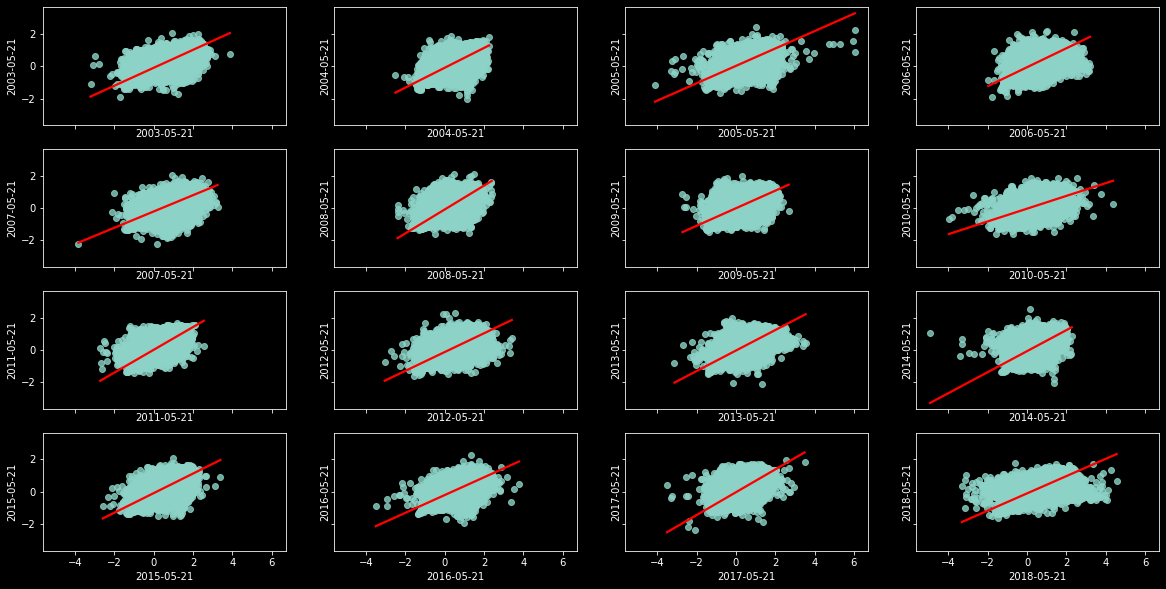

In [135]:
fig, axes = plt.subplots(4, 4, figsize=(20, 10), sharey=True, sharex=True)
sns.regplot(ndvi_table_lct_crop_rain['2003-05-21'], ndvi_simplex_pi6T_crop_rain['2003-05-21'],line_kws={"color": "red"},ax=axes[0,0])
sns.regplot(ndvi_table_lct_crop_rain['2004-05-21'], ndvi_simplex_pi6T_crop_rain['2004-05-21'],line_kws={"color": "red"},ax=axes[0,1])
sns.regplot(ndvi_table_lct_crop_rain['2005-05-21'], ndvi_simplex_pi6T_crop_rain['2005-05-21'],line_kws={"color": "red"},ax=axes[0,2])
sns.regplot(ndvi_table_lct_crop_rain['2006-05-21'], ndvi_simplex_pi6T_crop_rain['2006-05-21'],line_kws={"color": "red"},ax=axes[0,3])
sns.regplot(ndvi_table_lct_crop_rain['2007-05-21'], ndvi_simplex_pi6T_crop_rain['2007-05-21'],line_kws={"color": "red"},ax=axes[1,0])
sns.regplot(ndvi_table_lct_crop_rain['2008-05-21'], ndvi_simplex_pi6T_crop_rain['2008-05-21'],line_kws={"color": "red"},ax=axes[1,1])
sns.regplot(ndvi_table_lct_crop_rain['2009-05-21'], ndvi_simplex_pi6T_crop_rain['2009-05-21'],line_kws={"color": "red"},ax=axes[1,2])
sns.regplot(ndvi_table_lct_crop_rain['2010-05-21'], ndvi_simplex_pi6T_crop_rain['2010-05-21'],line_kws={"color": "red"},ax=axes[1,3])
sns.regplot(ndvi_table_lct_crop_rain['2011-05-21'], ndvi_simplex_pi6T_crop_rain['2011-05-21'],line_kws={"color": "red"},ax=axes[2,0])
sns.regplot(ndvi_table_lct_crop_rain['2012-05-21'], ndvi_simplex_pi6T_crop_rain['2012-05-21'],line_kws={"color": "red"},ax=axes[2,1])
sns.regplot(ndvi_table_lct_crop_rain['2013-05-21'], ndvi_simplex_pi6T_crop_rain['2013-05-21'],line_kws={"color": "red"},ax=axes[2,2])
sns.regplot(ndvi_table_lct_crop_rain['2014-05-21'], ndvi_simplex_pi6T_crop_rain['2014-05-21'],line_kws={"color": "red"},ax=axes[2,3])
sns.regplot(ndvi_table_lct_crop_rain['2015-05-21'], ndvi_simplex_pi6T_crop_rain['2015-05-21'],line_kws={"color": "red"},ax=axes[3,0])
sns.regplot(ndvi_table_lct_crop_rain['2016-05-21'], ndvi_simplex_pi6T_crop_rain['2016-05-21'],line_kws={"color": "red"},ax=axes[3,1])
sns.regplot(ndvi_table_lct_crop_rain['2017-05-21'], ndvi_simplex_pi6T_crop_rain['2017-05-21'],line_kws={"color": "red"},ax=axes[3,2])
sns.regplot(ndvi_table_lct_crop_rain['2018-05-21'], ndvi_simplex_pi6T_crop_rain['2018-05-21'],line_kws={"color": "red"},ax=axes[3,3])

fig.xlabel('Observations')
fig.ylabel('Predictions')

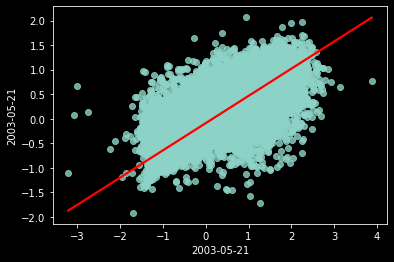

In [118]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (22,10))
sns.regplot(ndvi_table_lct_crop_rain['2003-05-21'], ndvi_simplex_pi6T_crop_rain['2003-05-21'],line_kws={"color": "red"}, ax = ax1)
#plt.scatter(ndvi_table_lct_crop_rain['2004-05-21'], ndvi_simplex_pi6T_crop_rain['2004-05-21'], alpha = 0.5)

# EOS Maps

In [16]:
ndvi_ci_table = pd.read_csv(observations_tables + 'ndvi_ci_table_anom.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_cr_table = pd.read_csv(observations_tables + 'ndvi_cr_table_anom.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])

In [94]:
ndvi_ci_tableT = ndvi_ci_table.T
ndvi_cr_tableT = ndvi_cr_table.T

In [95]:
ndvi_ci_tableT.columns = dekads.strftime("%Y-%m-%d").tolist()
ndvi_cr_tableT.columns = dekads.strftime("%Y-%m-%d").tolist()

In [159]:
#ci_residual_df = pd.DataFrame(list(range(1,392943)), columns = ['pix_id'])

In [160]:
#ci_residual_df['05-21-11_pi1'] = ndvi_ci_tableT['2011-05-21']-ndvi_ea_simplex_ed6_pi1T['2011-05-21']
#ci_residual_df['05-21-11_pi5'] = ndvi_ci_tableT['2011-05-21']-ndvi_ea_simplex_ed6_pi5T['2011-05-21']
#ci_residual_df['05-21-11_pi10'] = ndvi_ci_tableT['2011-05-21']-ndvi_ea_simplex_ed6_pi10T['2011-05-21']

In [238]:
residual_05_21_11_pi1_ci = ndvi_ea_simplex_ed6_pi1T['2011-05-21'].values - ndvi_ci_tableT['2011-05-21'].values
residual_05_21_11_pi1_cr = ndvi_ea_simplex_ed6_pi1T['2011-05-21'].values - ndvi_cr_tableT['2011-05-21'].values

residual_05_21_11_pi5_ci = ndvi_ea_simplex_ed6_pi5T['2011-05-21'].values - ndvi_ci_tableT['2011-05-21'].values
residual_05_21_11_pi5_cr = ndvi_ea_simplex_ed6_pi5T['2011-05-21'].values - ndvi_cr_tableT['2011-05-21'].values  

residual_05_21_11_pi10_ci = ndvi_ea_simplex_ed6_pi10T['2011-05-21'].values - ndvi_ci_tableT['2011-05-21'].values  
residual_05_21_11_pi10_cr = ndvi_ea_simplex_ed6_pi10T['2011-05-21'].values - ndvi_cr_tableT['2011-05-21'].values  

residual_12_21_11_pi1_ci = ndvi_ea_simplex_ed6_pi1T['2011-12-21'].values - ndvi_ci_tableT['2011-12-21'].values 
residual_12_21_11_pi1_cr = ndvi_ea_simplex_ed6_pi1T['2011-12-21'].values - ndvi_cr_tableT['2011-12-21'].values 

residual_12_21_11_pi5_ci = ndvi_ea_simplex_ed6_pi5T['2011-12-21'].values - ndvi_ci_tableT['2011-12-21'].values  
residual_12_21_11_pi5_cr = ndvi_ea_simplex_ed6_pi5T['2011-12-21'].values - ndvi_cr_tableT['2011-12-21'].values 

residual_12_21_11_pi10_ci = ndvi_ea_simplex_ed6_pi10T['2011-12-21'].values - ndvi_ci_tableT['2011-12-21'].values  
residual_12_21_11_pi10_cr = ndvi_ea_simplex_ed6_pi10T['2011-12-21'].values - ndvi_cr_tableT['2011-12-21'].values

In [239]:
residual_05_21_11_pi1_ci_0s = np.nan_to_num(residual_05_21_11_pi1_ci, copy=True, nan=0.0, posinf=None, neginf=None)
residual_05_21_11_pi1_cr_0s = np.nan_to_num(residual_05_21_11_pi1_cr, copy=True, nan=0.0, posinf=None, neginf=None)

residual_05_21_11_pi5_ci_0s = np.nan_to_num(residual_05_21_11_pi5_ci, copy=True, nan=0.0, posinf=None, neginf=None)
residual_05_21_11_pi5_cr_0s = np.nan_to_num(residual_05_21_11_pi5_cr, copy=True, nan=0.0, posinf=None, neginf=None)

residual_05_21_11_pi10_ci_0s = np.nan_to_num(residual_05_21_11_pi10_ci, copy=True, nan=0.0, posinf=None, neginf=None)
residual_05_21_11_pi10_cr_0s = np.nan_to_num(residual_05_21_11_pi10_cr, copy=True, nan=0.0, posinf=None, neginf=None)

residual_12_21_11_pi1_ci_0s = np.nan_to_num(residual_12_21_11_pi1_ci, copy=True, nan=0.0, posinf=None, neginf=None)
residual_12_21_11_pi1_cr_0s = np.nan_to_num(residual_12_21_11_pi1_cr, copy=True, nan=0.0, posinf=None, neginf=None)

residual_12_21_11_pi5_ci_0s = np.nan_to_num(residual_12_21_11_pi5_ci, copy=True, nan=0.0, posinf=None, neginf=None)
residual_12_21_11_pi5_cr_0s = np.nan_to_num(residual_12_21_11_pi5_cr, copy=True, nan=0.0, posinf=None, neginf=None)

residual_12_21_11_pi10_ci_0s = np.nan_to_num(residual_12_21_11_pi10_ci, copy=True, nan=0.0, posinf=None, neginf=None)
residual_12_21_11_pi10_cr_0s = np.nan_to_num(residual_12_21_11_pi10_cr, copy=True, nan=0.0, posinf=None, neginf=None)

In [240]:
residuals_05_21_11_pi1 = residual_05_21_11_pi1_ci_0s+residual_05_21_11_pi1_cr_0s
residuals_05_21_11_pi5 = residual_05_21_11_pi5_ci_0s+residual_05_21_11_pi5_cr_0s
residuals_05_21_11_pi10 = residual_05_21_11_pi10_ci_0s+residual_05_21_11_pi10_cr_0s

residuals_12_21_11_pi1 = residual_12_21_11_pi1_ci_0s+residual_12_21_11_pi1_cr_0s
residuals_12_21_11_pi5 = residual_12_21_11_pi5_ci_0s+residual_12_21_11_pi5_cr_0s
residuals_12_21_11_pi10 = residual_12_21_11_pi10_ci_0s+residual_12_21_11_pi10_cr_0s

In [241]:
residuals_05_21_11_pi1[residuals_05_21_11_pi1==0] = np.nan
residuals_05_21_11_pi5[residuals_05_21_11_pi5==0] = np.nan
residuals_05_21_11_pi10[residuals_05_21_11_pi10==0] = np.nan

residuals_12_21_11_pi1[residuals_12_21_11_pi1==0] = np.nan
residuals_12_21_11_pi5[residuals_12_21_11_pi5==0] = np.nan
residuals_12_21_11_pi10[residuals_12_21_11_pi10==0] = np.nan

In [243]:
residuals_05_21_11_pi1_rs = np.reshape(list(residuals_05_21_11_pi1), (674,583))
residuals_05_21_11_pi5_rs = np.reshape(list(residuals_05_21_11_pi5), (674,583))
residuals_05_21_11_pi10_rs = np.reshape(list(residuals_05_21_11_pi10), (674,583))

residuals_12_21_11_pi1_rs = np.reshape(list(residuals_12_21_11_pi1), (674,583))
residuals_12_21_11_pi5_rs = np.reshape(list(residuals_12_21_11_pi5), (674,583))
residuals_12_21_11_pi10_rs = np.reshape(list(residuals_12_21_11_pi10), (674,583))

In [258]:
def array2tiff(array, in_dir, out_dir, out_name):
    
    '''
    This function converts a 2D array into a tif using the profile of an existing tif

    '''
    

    with rasterio.open(in_dir+ os.listdir(in_dir)[0]) as src:
        profile = src.profile

    with rasterio.open(out_dir + out_name + '.tif', 'w', **profile) as dst:
        data = array
        data = data.astype(np.float32)
        #data[data<=0] = np.nan
        dst.write(data, indexes=1)


In [263]:
array2tiff(residuals_05_21_11_pi1_rs, ndvi_ea, EOS_maps, 'residuals_05_21_11_pi1')
array2tiff(residuals_05_21_11_pi5_rs, ndvi_ea, EOS_maps, 'residuals_05_21_11_pi5)
array2tiff(residuals_05_21_11_pi10_rs, ndvi_ea, EOS_maps, 'residuals_05_21_11_pi10')

array2tiff(residuals_12_21_11_pi1_rs, ndvi_ea, EOS_maps, 'residuals_12_21_11_pi1')
array2tiff(residuals_12_21_11_pi5_rs, ndvi_ea, EOS_maps, 'residuals_12_21_11_pi5')
array2tiff(residuals_12_21_11_pi10_rs, ndvi_ea, EOS_maps, 'residuals_12_21_11_pi10')

In [270]:
def mask_raster_shp(shp, raster, out_name, in_dir, out_dir):
    
    '''
    This function masks a raster to the shape of a smaller shapefile and creates a new raster
    
    '''
    with fiona.open(shp, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    with rasterio.open(in_dir + raster) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, nodata = 0, crop=True)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(out_dir + out_name, "w", **out_meta) as dest:
        out_image[out_image == 0] = np.nan  
        dest.write(out_image)

In [277]:
mask_raster_shp(ea_boundary, 'residuals_05_21_11_pi1.tif', 'residuals_05_21_11_pi1_clip.tif', EOS_maps, EOS_maps)
mask_raster_shp(ea_boundary, 'residuals_05_21_11_pi5.tif', 'residuals_05_21_11_pi5_clip.tif', EOS_maps, EOS_maps)
mask_raster_shp(ea_boundary, 'residuals_05_21_11_pi10.tif', 'residuals_05_21_11_pi10_clip.tif', EOS_maps, EOS_maps)

mask_raster_shp(ea_boundary, 'residuals_12_21_11_pi1.tif', 'residuals_12_21_11_pi1_clip.tif', EOS_maps, EOS_maps)
mask_raster_shp(ea_boundary, 'residuals_12_21_11_pi5.tif', 'residuals_12_21_11_pi5_clip.tif', EOS_maps, EOS_maps)
mask_raster_shp(ea_boundary, 'residuals_12_21_11_pi10.tif', 'residuals_12_21_11_pi10_clip.tif', EOS_maps, EOS_maps)

In [278]:
residuals_05_21_11_pi1 = rasterio.open(EOS_maps + 'residuals_05_21_11_pi1_clip.tif')
residuals_05_21_11_pi5 = rasterio.open(EOS_maps + 'residuals_05_21_11_pi5_clip.tif')
residuals_05_21_11_pi10 = rasterio.open(EOS_maps + 'residuals_05_21_11_pi10_clip.tif')

residuals_12_21_11_pi1 = rasterio.open(EOS_maps + 'residuals_12_21_11_pi1_clip.tif')
residuals_12_21_11_pi5 = rasterio.open(EOS_maps + 'residuals_12_21_11_pi5_clip.tif')
residuals_12_21_11_pi10 = rasterio.open(EOS_maps + 'residuals_12_21_11_pi10_clip.tif')

In [285]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

AttributeError: 'AxesSubplot' object has no attribute 'get_array'

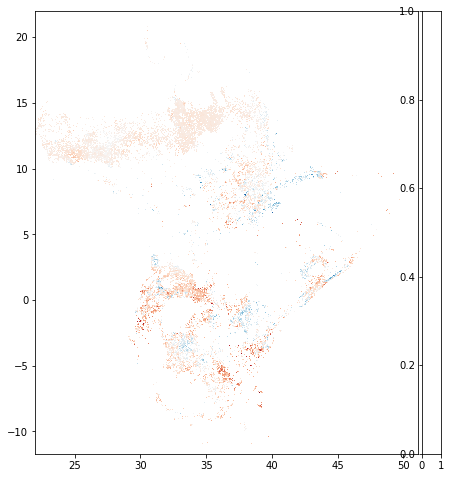

In [293]:
import numpy as np

m1 = np.random.rand(3, 3)
m2 = np.arange(0, 3*3, 1).reshape((3, 3))

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
im1 = show(residuals_05_21_11_pi10, ax = ax1, cmap = 'RdBu')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(m2, interpolation='None')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

AttributeError: 'AxesSubplot' object has no attribute 'get_array'

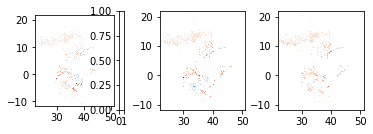

In [291]:
fig = plt.figure()
ax1 = fig.add_subplot(231)
im1 = show(residuals_05_21_11_pi10, ax = ax1, cmap = 'RdBu')
#im1.set_clim(vmin,vmax)
ax2 = fig.add_subplot(232)
mesh1 = show(residuals_05_21_11_pi5, ax = ax2, cmap = 'RdBu')
#mesh1.set_clim(vmin,vmax)
ax3 = fig.add_subplot(233)
mesh2 = show(residuals_05_21_11_pi1, ax = ax3, cmap = 'RdBu')
#mesh2.set_clim(vmin,vmax)
# Visualizing colorbar part -start
fig.colorbar(im1,ax=ax1)
fig.colorbar(mesh1,ax=ax2)
fig.colorbar(mesh2,ax=ax3)
fig.tight_layout()

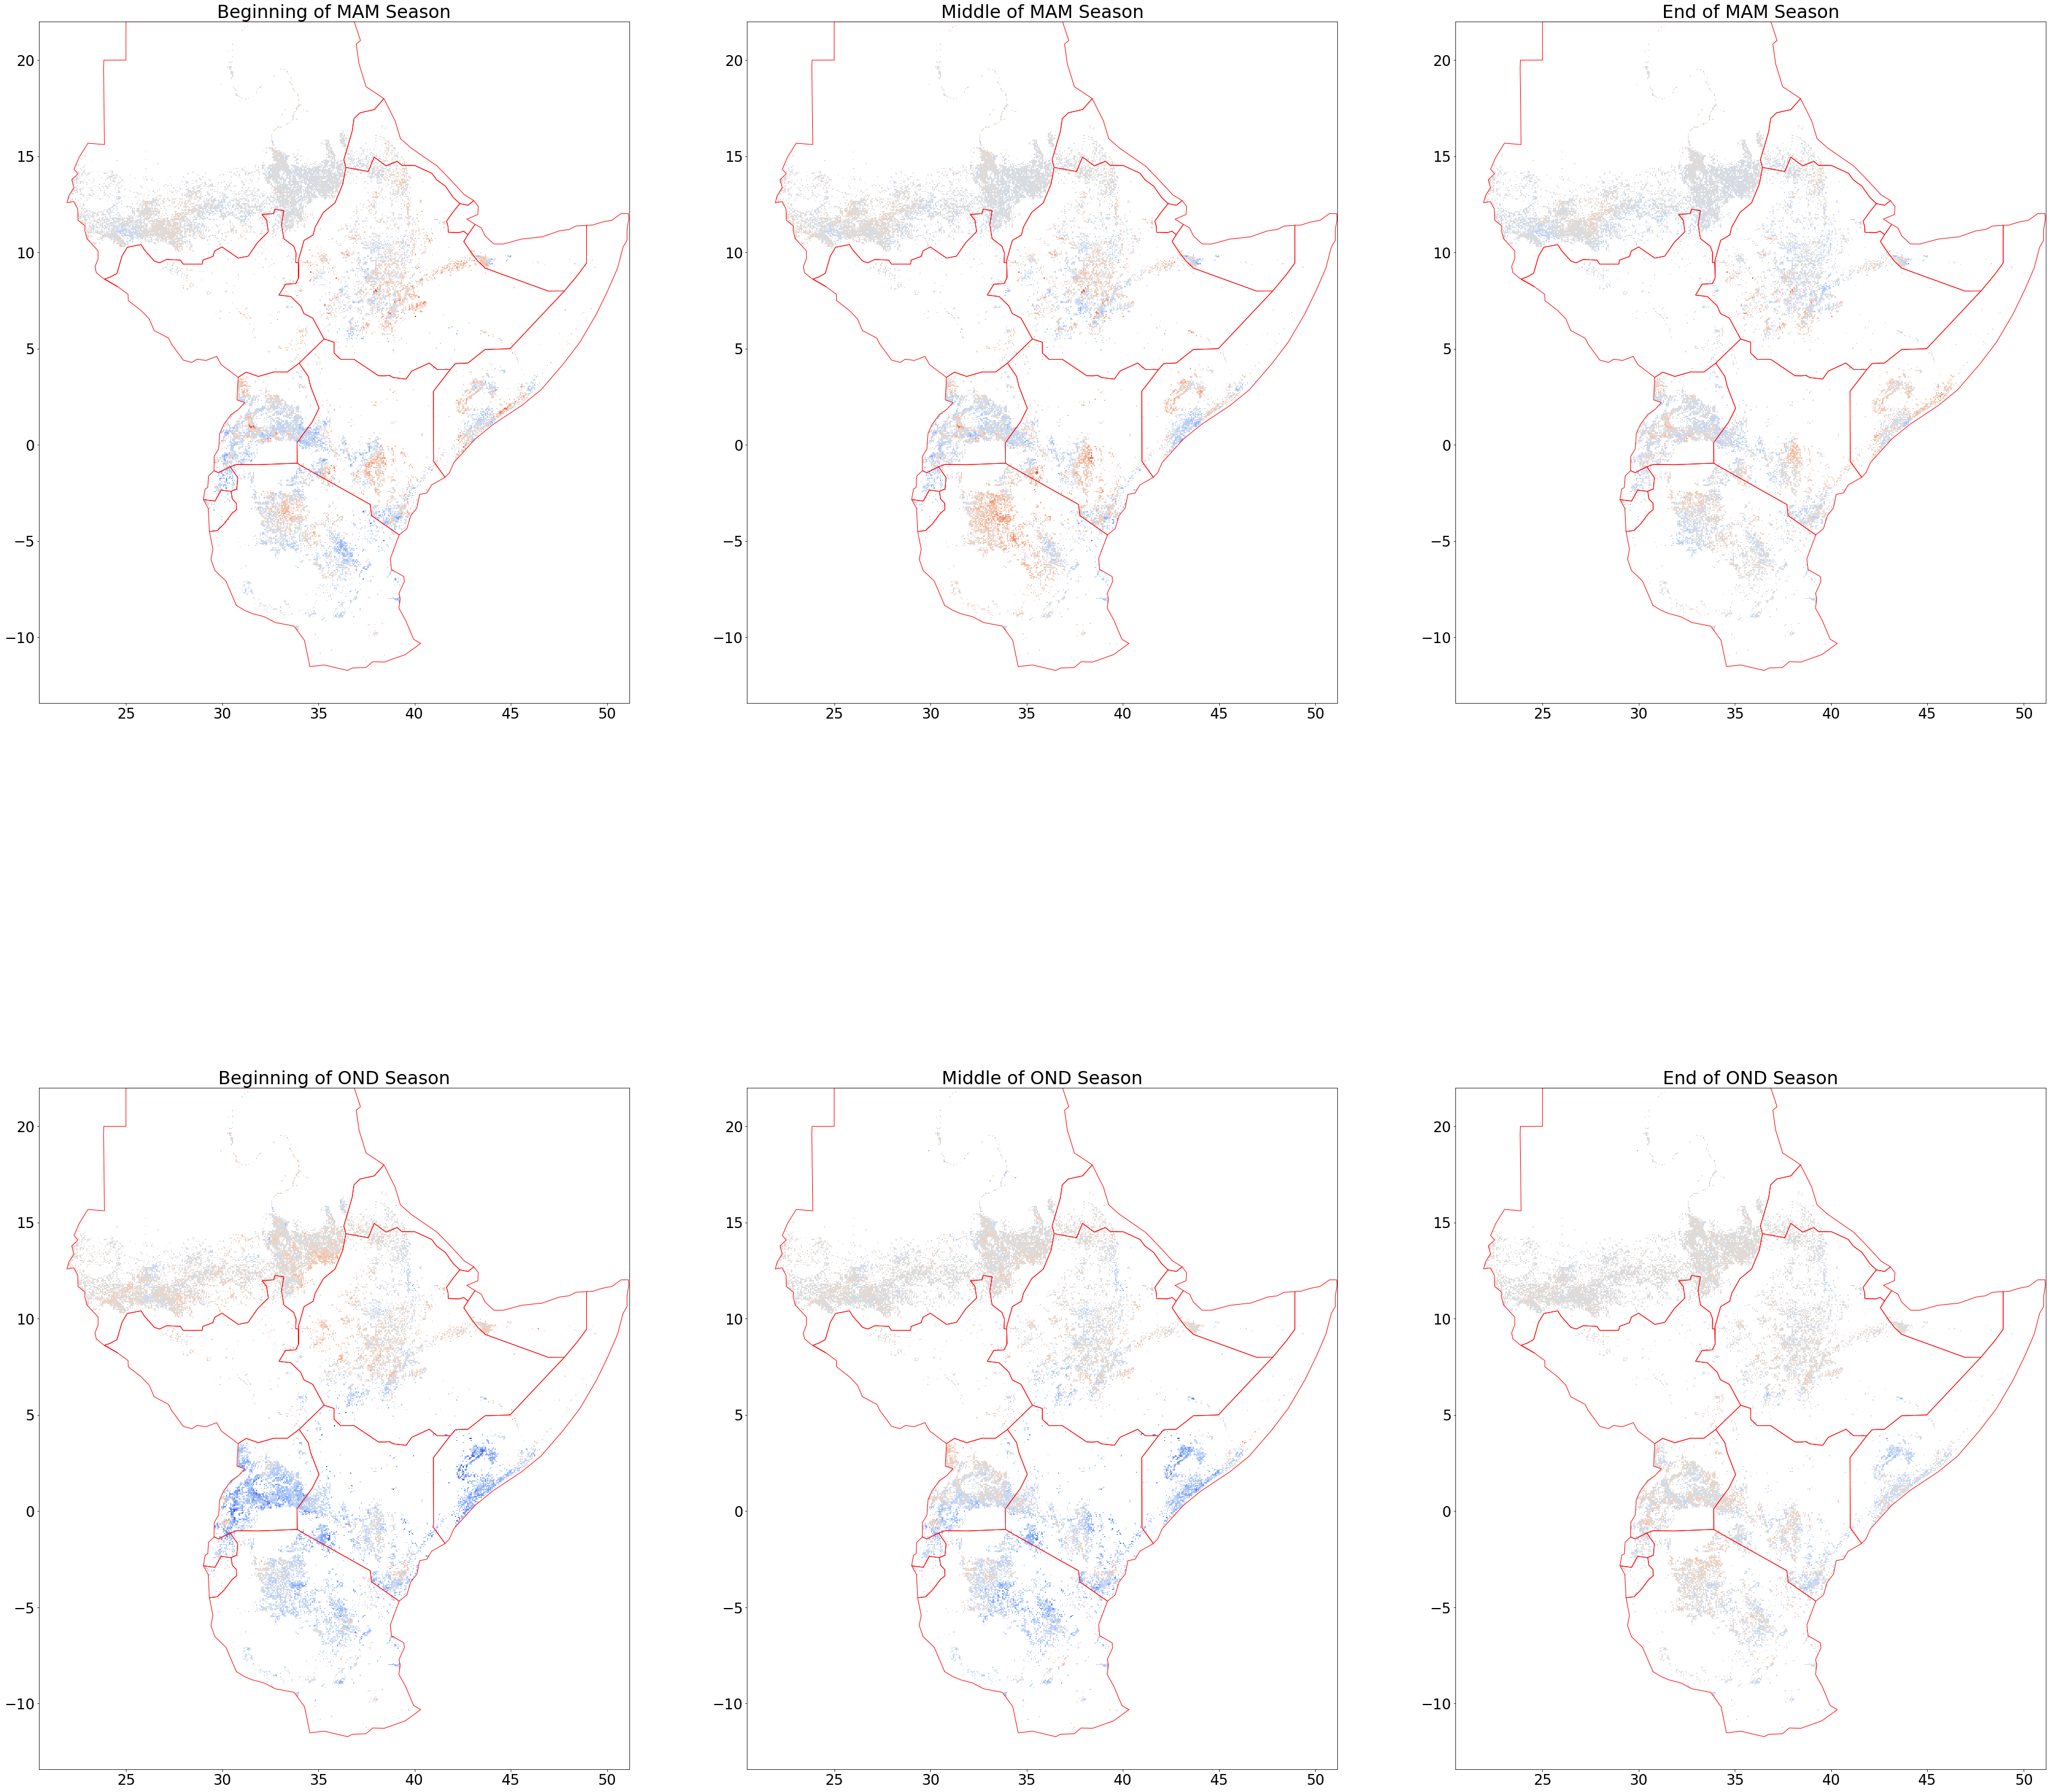

In [343]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(60,60))

# image_hidden = ax.imshow(residuals_05_21_11_pi10_rs, 
#                          cmap='RdBu')

# # plot on the same axis with rio.plot.show
# image = show(residuals_05_21_11_pi10, ax=ax1, cmap='RdBu') 
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)


# fig.colorbar(image_hidden, cax=cax)
show(residuals_05_21_11_pi10, ax= ax1, cmap = 'coolwarm', vmin = -3, vmax = 3)
show(residuals_05_21_11_pi5, ax= ax2, cmap = 'coolwarm', vmin = -3, vmax = 3)
show(residuals_05_21_11_pi1, ax = ax3, cmap = 'coolwarm',vmin = -3, vmax = 3)
show(residuals_12_21_11_pi10, ax= ax4, cmap = 'coolwarm',vmin = -3, vmax = 3)
show(residuals_12_21_11_pi5, ax = ax5, cmap = 'coolwarm',vmin = -3, vmax = 3)
show(residuals_12_21_11_pi1, ax = ax6, cmap = 'coolwarm',vmin = -3, vmax = 3)

ax1.set_title('Beginning of MAM Season', fontsize = 30)
ax2.set_title('Middle of MAM Season', fontsize = 30)
ax3.set_title('End of MAM Season', fontsize = 30)
ax4.set_title('Beginning of OND Season', fontsize = 30)
ax5.set_title('Middle of OND Season', fontsize = 30)
ax6.set_title('End of OND Season', fontsize = 30)

EastAfrica_basemap.plot(ax=ax1, facecolor='none', edgecolor='red')
EastAfrica_basemap.plot(ax=ax2, facecolor='none', edgecolor='red')
EastAfrica_basemap.plot(ax=ax3, facecolor='none', edgecolor='red')
EastAfrica_basemap.plot(ax=ax4, facecolor='none', edgecolor='red')
EastAfrica_basemap.plot(ax=ax5, facecolor='none', edgecolor='red')
EastAfrica_basemap.plot(ax=ax6, facecolor='none', edgecolor='red')

ax1.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax4.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax5.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax6.tick_params(axis = 'both', which = 'major', labelsize = 24)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)



# cmapProp = {'drawedges': True, 'boundaries': np.linspace(0, 1, 13, endpoint=True).round(2)}
# cbar = ax1.figure.colorbar(hidden_ax1, ax=ax1, **cmapProp)
# cbar.ax.tick_params(labelsize=25)  # set your label size here

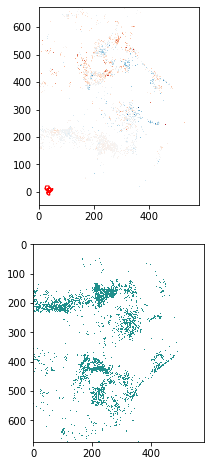

In [331]:
fig, ax = plt.subplots(2,1,figsize=(12,8)) # Caution, figsize will also influence positions.
hidden_im1 = ax[0].imshow(residuals_05_21_11_pi10_rs, cmap = 'RdBu', vmin = -3, vmax = 3)
im1 = show(residuals_05_21_11_pi10, ax = ax[0], cmap = 'RdBu', vmin = -3, vmax = 3)
EastAfrica_basemap.plot(ax=ax[0], facecolor='none', edgecolor='red')

hidden_im2 = ax[1].imshow(residuals_05_21_11_pi5_rs, vmin = -100, vmax =100)
#fig.colorbar(hidden_im1, ax=ax)

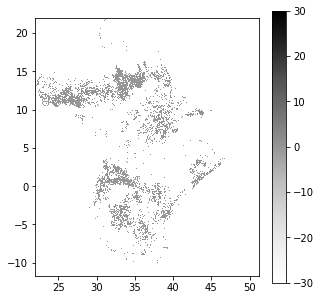

In [307]:
fig, ax = plt.subplots(figsize=(5, 5))

# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(residuals_05_21_11_pi10_rs, 
                         cmap='Greys', 
                         vmin=-30, 
                         vmax=30)

# plot on the same axis with rio.plot.show
image = show(residuals_05_21_11_pi10, 
                       
                      ax=ax, 
                      cmap='Greys', 
                      vmin=-30, 
                      vmax=30)

# add colorbar using the now hidden image
fig.colorbar(image_hidden, ax=ax)

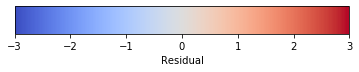

In [345]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=-3, vmax=3)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Residual')  
plt.savefig('/home/rgreen/colorbar_coolwarm3', dpi = 300)

percent change

In [248]:
pc_05_21_11_pi1_ci = (ndvi_ea_simplex_ed6_pi1T['2011-05-21'].values - ndvi_ci_tableT['2011-05-21'].values)/ndvi_ci_tableT['2011-05-21'].values
pc_05_21_11_pi1_cr = (ndvi_ea_simplex_ed6_pi1T['2011-05-21'].values - ndvi_cr_tableT['2011-05-21'].values)/ndvi_cr_tableT['2011-05-21'].values

pc_05_21_11_pi5_ci = (ndvi_ea_simplex_ed6_pi5T['2011-05-21'].values - ndvi_ci_tableT['2011-05-21'].values)/ndvi_ci_tableT['2011-05-21'].values
pc_05_21_11_pi5_cr = (ndvi_ea_simplex_ed6_pi5T['2011-05-21'].values - ndvi_cr_tableT['2011-05-21'].values)/ndvi_cr_tableT['2011-05-21'].values 

pc_05_21_11_pi10_ci = (ndvi_ea_simplex_ed6_pi10T['2011-05-21'].values - ndvi_ci_tableT['2011-05-21'].values)/ndvi_ci_tableT['2011-05-21'].values 
pc_05_21_11_pi10_cr = (ndvi_ea_simplex_ed6_pi10T['2011-05-21'].values - ndvi_cr_tableT['2011-05-21'].values)/ndvi_cr_tableT['2011-05-21'].values 

pc_12_21_11_pi1_ci = (ndvi_ea_simplex_ed6_pi1T['2011-12-21'].values - ndvi_ci_tableT['2011-12-21'].values)/ndvi_ci_tableT['2011-12-21'].values
pc_12_21_11_pi1_cr = (ndvi_ea_simplex_ed6_pi1T['2011-12-21'].values - ndvi_cr_tableT['2011-12-21'].values)/ndvi_cr_tableT['2011-12-21'].values

pc_12_21_11_pi5_ci = (ndvi_ea_simplex_ed6_pi5T['2011-12-21'].values - ndvi_ci_tableT['2011-12-21'].values)/ndvi_ci_tableT['2011-12-21'].values 
pc_12_21_11_pi5_cr = (ndvi_ea_simplex_ed6_pi5T['2011-12-21'].values - ndvi_cr_tableT['2011-12-21'].values)/ndvi_cr_tableT['2011-12-21'].values

pc_12_21_11_pi10_ci = (ndvi_ea_simplex_ed6_pi10T['2011-12-21'].values - ndvi_ci_tableT['2011-12-21'].values)/ndvi_ci_tableT['2011-12-21'].values  
pc_12_21_11_pi10_cr = (ndvi_ea_simplex_ed6_pi10T['2011-12-21'].values - ndvi_cr_tableT['2011-12-21'].values)/ndvi_cr_tableT['2011-12-21'].values

In [249]:
pc_05_21_11_pi1_ci_0s = np.nan_to_num(pc_05_21_11_pi1_ci, copy=True, nan=0.0, posinf=None, neginf=None)
pc_05_21_11_pi1_cr_0s = np.nan_to_num(pc_05_21_11_pi1_cr, copy=True, nan=0.0, posinf=None, neginf=None)

pc_05_21_11_pi5_ci_0s = np.nan_to_num(pc_05_21_11_pi5_ci, copy=True, nan=0.0, posinf=None, neginf=None)
pc_05_21_11_pi5_cr_0s = np.nan_to_num(pc_05_21_11_pi5_cr, copy=True, nan=0.0, posinf=None, neginf=None)

pc_05_21_11_pi10_ci_0s = np.nan_to_num(pc_05_21_11_pi10_ci, copy=True, nan=0.0, posinf=None, neginf=None)
pc_05_21_11_pi10_cr_0s = np.nan_to_num(pc_05_21_11_pi10_cr, copy=True, nan=0.0, posinf=None, neginf=None)

pc_12_21_11_pi1_ci_0s = np.nan_to_num(pc_12_21_11_pi1_ci, copy=True, nan=0.0, posinf=None, neginf=None)
pc_12_21_11_pi1_cr_0s = np.nan_to_num(pc_12_21_11_pi1_cr, copy=True, nan=0.0, posinf=None, neginf=None)

pc_12_21_11_pi5_ci_0s = np.nan_to_num(pc_12_21_11_pi5_ci, copy=True, nan=0.0, posinf=None, neginf=None)
pc_12_21_11_pi5_cr_0s = np.nan_to_num(pc_12_21_11_pi5_cr, copy=True, nan=0.0, posinf=None, neginf=None)

pc_12_21_11_pi10_ci_0s = np.nan_to_num(pc_12_21_11_pi10_ci, copy=True, nan=0.0, posinf=None, neginf=None)
pc_12_21_11_pi10_cr_0s = np.nan_to_num(pc_12_21_11_pi10_cr, copy=True, nan=0.0, posinf=None, neginf=None)

In [250]:
pc_05_21_11_pi1 = pc_05_21_11_pi1_ci_0s+pc_05_21_11_pi1_cr_0s
pc_05_21_11_pi5 = pc_05_21_11_pi5_ci_0s+pc_05_21_11_pi5_cr_0s
pc_05_21_11_pi10 = pc_05_21_11_pi10_ci_0s+pc_05_21_11_pi10_cr_0s

pc_12_21_11_pi1 = pc_12_21_11_pi1_ci_0s+pc_12_21_11_pi1_cr_0s
pc_12_21_11_pi5 = pc_12_21_11_pi5_ci_0s+pc_12_21_11_pi5_cr_0s
pc_12_21_11_pi10 = pc_12_21_11_pi10_ci_0s+pc_12_21_11_pi10_cr_0s

In [251]:
pc_05_21_11_pi1[pc_05_21_11_pi1==0] = np.nan
pc_05_21_11_pi5[pc_05_21_11_pi5==0] = np.nan
pc_05_21_11_pi10[pc_05_21_11_pi10==0] = np.nan

pc_12_21_11_pi1[pc_12_21_11_pi1==0] = np.nan
pc_12_21_11_pi5[pc_12_21_11_pi5==0] = np.nan
pc_12_21_11_pi10[pc_12_21_11_pi10==0] = np.nan

In [252]:
pc_05_21_11_pi1_rs = np.reshape(list(pc_05_21_11_pi1), (674,583))
pc_05_21_11_pi5_rs = np.reshape(list(pc_05_21_11_pi5), (674,583))
pc_05_21_11_pi10_rs = np.reshape(list(pc_05_21_11_pi10), (674,583))

pc_12_21_11_pi1_rs = np.reshape(list(pc_12_21_11_pi1), (674,583))
pc_12_21_11_pi5_rs = np.reshape(list(pc_12_21_11_pi5), (674,583))
pc_12_21_11_pi10_rs = np.reshape(list(pc_12_21_11_pi10), (674,583))

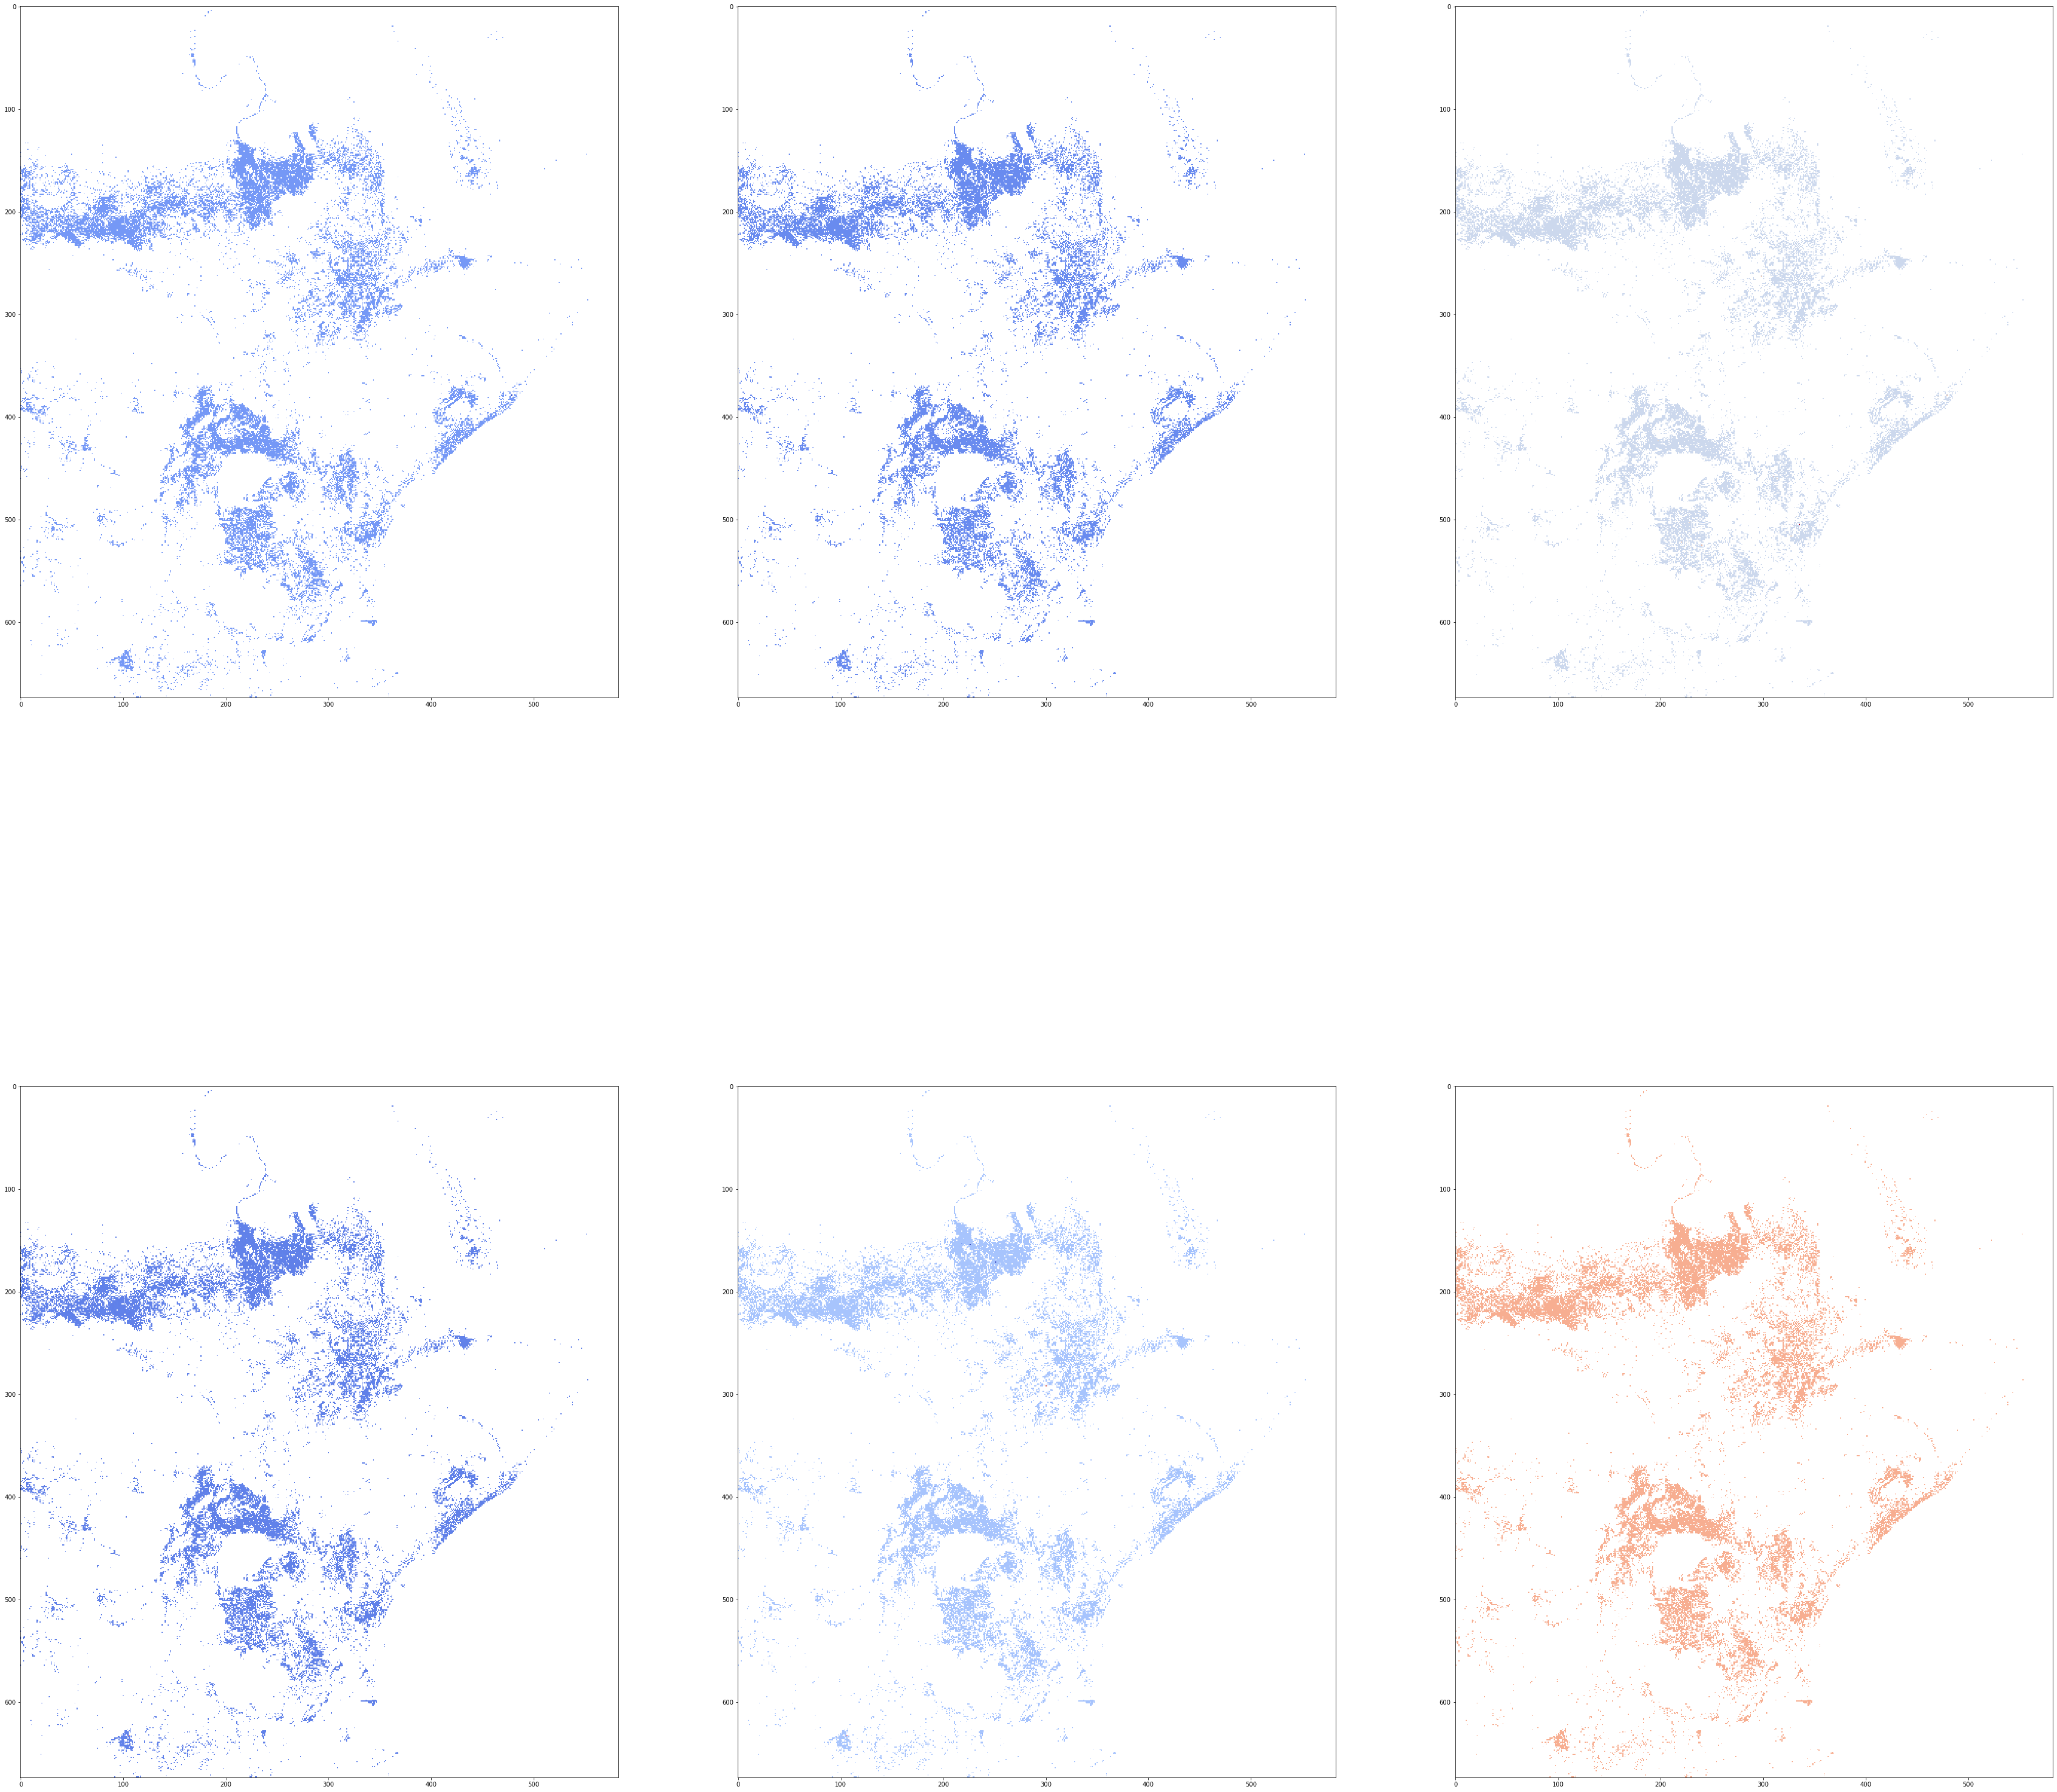

In [253]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(60,60))

show(pc_05_21_11_pi1_rs, ax = ax1, cmap = 'coolwarm')
show(pc_05_21_11_pi5_rs, ax= ax2, cmap = 'coolwarm')
show(pc_05_21_11_pi10_rs, ax = ax3, cmap = 'coolwarm')
show(pc_12_21_11_pi1_rs, ax= ax4, cmap = 'coolwarm')
show(pc_12_21_11_pi5_rs, ax = ax5, cmap = 'coolwarm')
show(pc_12_21_11_pi10_rs, ax = ax6, cmap = 'coolwarm')